# Import

In [18]:
from pathlib import Path
from typing import Dict, Tuple, Iterable, Optional, List
import json
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
# RUNS_DIR = Path("/data/scastedo/runs_feb_10_failure_2")

# RUNS_DIR = Path("/data/scastedo/runs_feb_9_mitig_3")
# RUNS_DIR = Path("/data/scastedo/runs_feb_5_fast_2")
# RUNS_DIR = Path("/data/scastedo/A little Older/runs_feb_equilibrium_2")
# RUNS_DIR = Path('/home/castedo/Desktop/data_test/runs_feb_equilibrium_2')
# RUNS_DIR = Path('/DATA/scastedo/runs_feb_15_main')
RUNS_DIR = Path('/DATA/scastedo/runs_feb_18_long')

def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Optional[Iterable[float]] = None,
    rin_values: Optional[Iterable[float]] = None,
    eta_values: Optional[Iterable[float]] = None,
    temp_values: Optional[Iterable[float]] = None,
    sigma_theta_values: Optional[Iterable[float]] = None,
    idir_values: Optional[Iterable[float]] = None,
    trials: Optional[Iterable[int]] = None,
    threshold_active_fraction_values: Optional[Iterable[float]] = None,
    I_str_values: Optional[Iterable[float]] = None,
    I_sigma_values: Optional[Iterable[float]] = None,
    strict: bool = True,
    tol: float = 1e-12,
) -> Tuple[
    Dict[Tuple[float, float, float, float, float], np.ndarray],
    List[float],
    List[float],
    List[float],
    List[float],
    List[float],
    List[float],
    List[int],
    int,
    List[float],
    List[float],
    List[float],
]:
    """Load run metadata and state histories into tensors.

    Returns tensors keyed by (ampar, rin, sigma_temp, sigma_eta, sigma_theta)
    plus parameter axes and network parameter values from metadata.
    """
    def sorted_unique(values: Iterable[float]) -> List[float]:
        return sorted({v for v in values if v is not None})

    def in_allowed(value, allowed: Optional[Iterable[float]]) -> bool:
        if allowed is None:
            return True
        if value is None:
            return False
        if isinstance(value, (float, int)):
            return any(math.isclose(float(value), float(v), rel_tol=tol, abs_tol=tol) for v in allowed)
        return value in allowed

    def load_state_matrix(folder: Path) -> np.ndarray:
        history_file = folder / "state_history.npy"
        if not history_file.exists():
            raise FileNotFoundError(f"Missing state history file: {history_file}")
        states = np.load(history_file)  # generations x neurons
        if states.ndim != 2:
            raise ValueError(f"Expected 2-D array in {history_file}, got {states.shape}")
        return states.T  # neurons x generations

    meta_paths = sorted(runs_dir.glob("*/run_metadata.json"))
    if not meta_paths:
        raise FileNotFoundError(f"No run_metadata.json found under {runs_dir}")

    metas = [(p.parent, json.loads(p.read_text())) for p in meta_paths]
    specs = [m.get("spec", {}) for _, m in metas]
    net_params = [m.get("network_params", {}) for _, m in metas]

    if ampar_values is None:
        ampar_values = sorted_unique(s.get("ampar") for s in specs)
    else:
        ampar_values = list(ampar_values)
    if rin_values is None:
        rin_values = sorted_unique(s.get("rin") for s in specs)
    else:
        rin_values = list(rin_values)
    if eta_values is None:
        eta_values = sorted_unique(s.get("sigma_eta") for s in specs)
    else:
        eta_values = list(eta_values)
    if temp_values is None:
        temp_values = sorted_unique(s.get("sigma_temp") for s in specs)
    else:
        temp_values = list(temp_values)
    if sigma_theta_values is None:
        sigma_theta_values = sorted_unique(s.get("sigma_theta") for s in specs)
    else:
        sigma_theta_values = list(sigma_theta_values)
    if idir_values is None:
        idir_values = sorted_unique(s.get("idir") for s in specs)
    else:
        idir_values = list(idir_values)
    if trials is None:
        trials = sorted_unique(s.get("trial") for s in specs)
    else:
        trials = list(trials)

    if threshold_active_fraction_values is None:
        threshold_active_fraction_values = sorted_unique(
            p.get("threshold_active_fraction") for p in net_params
        )
        threshold_active_fraction_filter = None
    else:
        threshold_active_fraction_filter = list(threshold_active_fraction_values)
        threshold_active_fraction_values = threshold_active_fraction_filter
    if I_str_values is None:
        I_str_values = sorted_unique(p.get("I_str") for p in net_params)
        I_str_filter = None
    else:
        I_str_filter = list(I_str_values)
        I_str_values = I_str_filter
    if I_sigma_values is None:
        I_sigma_values = sorted_unique(p.get("sigma_input") for p in net_params)
        I_sigma_filter = None
    else:
        I_sigma_filter = list(I_sigma_values)
        I_sigma_values = I_sigma_filter

    _block_sizes = sorted_unique(s.get("block_size") for s in specs)
    BLOCK_SIZE = _block_sizes[0] if _block_sizes else 1
    if len(_block_sizes) > 1:
        print(f"Note: multiple block_size values found: {_block_sizes}")

    runs_by_key: Dict[Tuple[float, float, float, float, float], Dict[Tuple[float, int], Path]] = {}

    for run_dir, meta in metas:
        spec = meta.get("spec", {})
        net = meta.get("network_params", {})
        ampar = spec.get("ampar")
        rin = spec.get("rin")
        sigma_temp = spec.get("sigma_temp")
        sigma_eta = spec.get("sigma_eta")
        sigma_theta = spec.get("sigma_theta")
        idir = spec.get("idir")
        trial = spec.get("trial")
        threshold_active_fraction = net.get("threshold_active_fraction")
        I_str = net.get("I_str")
        I_sigma = net.get("sigma_input")

        if None in (ampar, rin, sigma_temp, sigma_eta, sigma_theta, idir, trial):
            continue

        if not in_allowed(ampar, ampar_values):
            continue
        if not in_allowed(rin, rin_values):
            continue
        if not in_allowed(sigma_temp, temp_values):
            continue
        if not in_allowed(sigma_eta, eta_values):
            continue
        if not in_allowed(sigma_theta, sigma_theta_values):
            continue
        if not in_allowed(idir, idir_values):
            continue
        if not in_allowed(trial, trials):
            continue
        if threshold_active_fraction_filter is not None and not in_allowed(threshold_active_fraction, threshold_active_fraction_filter):
            continue
        if I_str_filter is not None and not in_allowed(I_str, I_str_filter):
            continue
        if I_sigma_filter is not None and not in_allowed(I_sigma, I_sigma_filter):
            continue

        key = (ampar, rin, sigma_temp, sigma_eta, sigma_theta)
        runs_by_key.setdefault(key, {})[(idir, trial)] = run_dir

    tensors: Dict[Tuple[float, float, float, float, float], np.ndarray] = {}
    for key, mapping in runs_by_key.items():
        idir_blocks = []
        for idir in idir_values:
            trial_blocks = []
            for trial in trials:
                folder = mapping.get((idir, trial))
                if folder is None:
                    if strict:
                        raise KeyError(f"Missing run for key={key}, idir={idir}, trial={trial}")
                    continue
                trial_blocks.append(load_state_matrix(folder))
            if not trial_blocks:
                if strict:
                    raise KeyError(f"No trials found for key={key}, idir={idir}")
                continue
            trial_cube = np.stack(trial_blocks, axis=2)  # neurons x generations x trials
            idir_blocks.append(trial_cube)
        if not idir_blocks:
            if strict:
                raise KeyError(f"No idir blocks found for key={key}")
            continue
        tensors[key] = np.stack(idir_blocks, axis=3)  # neurons x generations x trials x idir

    if strict and not tensors:
        raise ValueError(f"No runs matched filters under {runs_dir}")

    return (
        tensors,
        ampar_values,
        rin_values,
        eta_values,
        temp_values,
        sigma_theta_values,
        idir_values,
        trials,
        BLOCK_SIZE,
        threshold_active_fraction_values,
        I_str_values,
        I_sigma_values,
    )


In [19]:
tensors, AMPAR_VALUES, RIN_VALUES, ETA_VALUES, TEMP_VALUES, SIG_THETA_VALUES, IDIR_VALUES, TRIAL_INDICES, BLOCK_SIZE, THRESH_ACTIVE_FRACTION_VALUES, I_STR_VALUES, I_SIGMA_VALUES = build_state_tensors()


# SNR vs Theta

In [43]:
from itertools import combinations
def compute_snrs(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    # State Shape ( neurons, generations, trials, idir )
    neurons, _, trials, idirs = state.shape
    trials = 1 
    snr_array = np.zeros((trials))
    for trial in range(trials):
        # sample state just once every block at half block size
        # sample_ids = np.arange(BLOCK_SIZE//2, state.shape[1], BLOCK_SIZE)
        # state = state[:, sample_ids, :, :]
        angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
        other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
        delta_mu = state[:, :, trial,angle].mean(axis=1) - state[:, :, trial,other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])

        snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
        snr_array[trial] = snr_1

    return snr_array

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)
    data_avg = data_avg[:,:,:]
    # data_avg = state[:,:,:,:]
    # deltas, snrs = [], []
    # # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    # for idir_i, idir_j in combinations(range(idirs), 2):
    #     delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
    #     deltas.append(delta_idir)
    #     snrs.append(compute_snrs(data_avg, idir_1=idir_values[idir_i], idir_2=idir_values[idir_j]))

    snrs = np.zeros((idirs,len(TRIAL_INDICES)))
    deltas  = np.zeros((idirs))
    idir_i = 0.5
    for idir_j in range(idirs):
      
        delta_idir = abs(idir_values[idir_j] - idir_i)
        deltas[idir_j] = delta_idir
        snrs[idir_j,:] = compute_snrs(data_avg, idir_1=idir_i, idir_2=idir_values[idir_j])

    return deltas, snrs
neurons = tensors[1,1,TEMP_VALUES[0],ETA_VALUES[0],SIG_THETA_VALUES[0]].shape[0]
# delta_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES)))
# snr_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len(TRIAL_INDICES)))

# delta_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES),  len(IDIR_VALUES)))
# snr_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), len(IDIR_VALUES), len(TRIAL_INDICES)))


number_dirs = len(IDIR_VALUES)

delta_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), number_dirs))
snr_final_fr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), number_dirs, len(TRIAL_INDICES)))

delta_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES),  number_dirs))
snr_final_ctr = np.zeros((len(TEMP_VALUES), len(ETA_VALUES),len(SIG_THETA_VALUES), number_dirs, len(TRIAL_INDICES)))

WINDOW =  BLOCK_SIZE*7 #--- IGNORE ---

for i, temp in enumerate(TEMP_VALUES):
    for j, eta in enumerate(ETA_VALUES):
        for k, sigma_theta in enumerate(SIG_THETA_VALUES):
            delta_final_fr[i,j,k,:], snr_final_fr[i,j,k,:,:] = compute_snr_per_delta(tensors[0.64,1.27,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)
            delta_final_ctr[i,j,k,:], snr_final_ctr[i,j,k,:,:] = compute_snr_per_delta(tensors[1,1,temp,eta,sigma_theta], IDIR_VALUES, window_size=WINDOW)


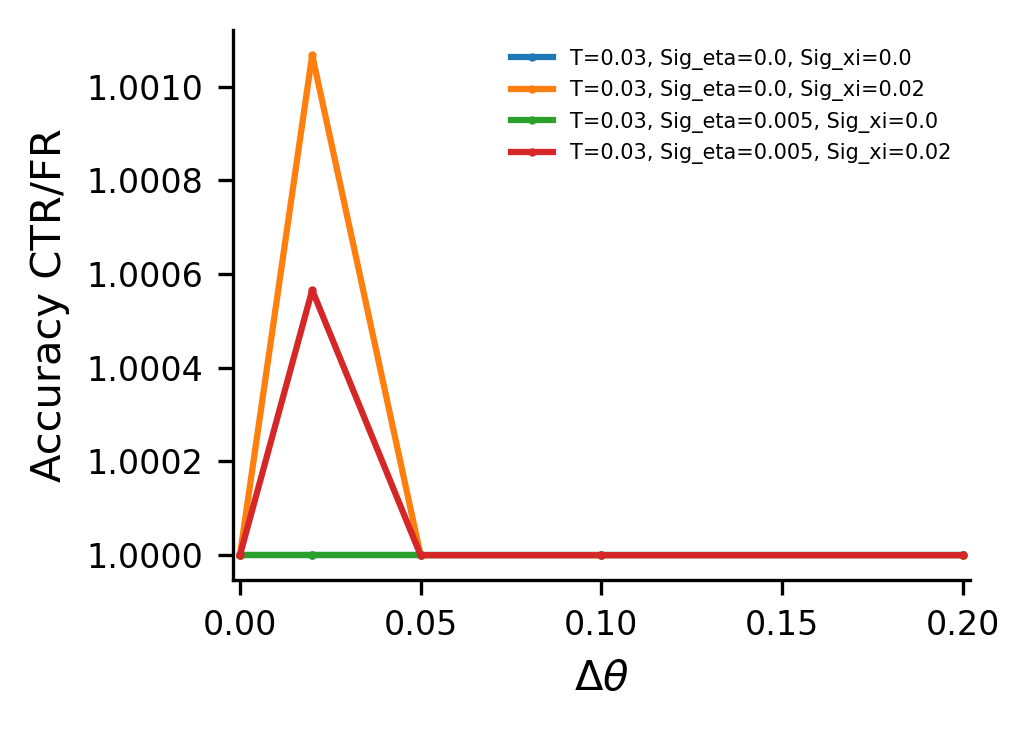

In [ ]:
from matplotlib import pyplot as plt

def snr_to_performance(snrval):
    dprime = np.sqrt(snrval)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)
    return perf
    # return snrval

def plottings(x,y, label, color):
    mean_y = y.mean(axis=1)
    sem_y = y.std(axis=1, ddof=1) / np.sqrt(y.shape[1])

    # for trial_idx in range(y.shape[1]):
        # ax.plot(x, y[:, trial_idx], lw=0.5, alpha=0.3, color = color)

    # only plot first 5 angles
    mean_y = mean_y#[:7]
    sem_y = sem_y#[:7]
    x = x#[:7]
    ax.plot(x, mean_y, lw=1, marker='o', linestyle='-', label=label, color=color)
    ax.fill_between(x, mean_y - sem_y, mean_y + sem_y, alpha=0.3, label="±1 SEM", color=color)


fig, ax = plt.subplots(figsize=(3.5, 2.5))  # good size for 1-column figure

deltas_plot = []
proportion_plot = []
for ETA in ETA_VALUES:
    for TEMP in TEMP_VALUES:
        for SIG_THETA in SIG_THETA_VALUES:

            delta = delta_final_ctr[TEMP_VALUES.index(TEMP),ETA_VALUES.index(ETA),SIG_THETA_VALUES.index(SIG_THETA)]
            ctr_snr = snr_to_performance(snr_final_ctr[TEMP_VALUES.index(TEMP),ETA_VALUES.index(ETA),SIG_THETA_VALUES.index(SIG_THETA)])
            fr_snr = snr_to_performance(snr_final_fr[TEMP_VALUES.index(TEMP),ETA_VALUES.index(ETA),SIG_THETA_VALUES.index(SIG_THETA)])
            deltas_plot.append(delta)
            proportion_plot.append(ctr_snr/fr_snr)
            plt.plot(delta, ctr_snr/fr_snr, 'o-',label=f"T={TEMP}, Sig_eta={ETA}, Sig_xi={SIG_THETA}")
            # plt.plot(delta, ctr_snr, 'x--',label=f"TEMP={TEMP}, ETA={ETA}, SIG_THETA={SIG_THETA}")
            # plt.plot(delta, fr_snr, 's--',label=f"TEMP={TEMP}, ETA={ETA}, SIG_THETA={SIG_THETA}")
            # plt.yscale('log')
            # plt.legend()
            # plt.show()
            


# for i in range(len(deltas_plot)):
#     delta_order = np.argsort(deltas_plot[i])
#     deltas_sorted = np.array(deltas_plot[i])[delta_order]
#     proportion_sorted = np.array(proportion_plot[i])[delta_order]
#     # average over bins of delta = 0.005
#     bin_size = 0.05
#     bins = np.arange(0, max(deltas_sorted) + bin_size, bin_size)
#     bin_indices = np.digitize(deltas_sorted, bins) - 1
#     binned_deltas = []
#     binned_proportions = []
#     for b in range(len(bins)):
#         in_bin = bin_indices == b
#         if np.any(in_bin):
#             binned_deltas.append(deltas_sorted[in_bin].mean())
#             binned_proportions.append(proportion_sorted[in_bin].mean())
#     deltas_sorted = np.array(binned_deltas)
#     proportion_sorted = np.array(binned_proportions)


#     plt.plot(deltas_sorted, proportion_sorted, 'o-')
# deltas_sorted = [np.array(deltas_plot)[np.argsort(deltas_plot)]]
# proportion_sorted = [np.array(proportion_plot)[np.argsort(deltas_plot)]]
# plt.plot(deltas_sorted[0], proportion_sorted[0], 'o-')
# plt.yscale('log')
# plt.ylim(0,5)
# plt.xlim(0,0.05)
plt.rcParams.update({
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.dpi": 300,
    "lines.markersize": 1,
})
# plt.xlim(0,0.05)
# plt.ylim(0,20)
# plt.axhline(y=0, color='gray', linestyle='--', lw=0.8)
ax.set_xlabel(r"$\Delta \theta$")
ax.set_ylabel("Accuracy CTR/FR")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# tighter x margins and layout
ax.margins(x=0.01)
ax.legend(frameon=False, fontsize=5, loc='upper right')
ax.ticklabel_format(axis='y', style='plain', useOffset=False)

fig.tight_layout()
# ax.invert_xaxis()

In [ ]:
ETA = ETA_VALUES[0]
TEMP = TEMP_VALUES[0]
SIG_THETA = SIG_THETA_VALUES[0]
tuning_curve_fr = tensors[0.64,1.27,TEMP,ETA,SIG_THETA].
print(tuning_curve_fr.shape)
# tuning_curve_ctr = tensors[1,1,TEMP,ETA,SIG_THETA].mean(axis=2).mean(axis=2)
# plt.plot(tuning_curve_fr.mean(axis=1), label='FR')
# plt.plot(tuning_curve_ctr.mean(axis=1), label='CTR')
# plt.legend()

(200, 500000, 1, 5)


In [16]:
ctr_results = snr_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)][:,0]
fr_results = snr_final_fr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)][:,0]
import pandas as pd
table = pd.DataFrame({
    "Delta Theta": delta_final_ctr[TEMP_VALUES.index(temp),ETA_VALUES.index(eta),SIG_THETA_VALUES.index(sigma_theta)],
    "CTR SNR": ctr_results,
    "FR SNR": fr_results
})
print(table)

   Delta Theta   CTR SNR    FR SNR
0         0.00  0.000000  0.000000
1         0.02  0.154532  0.095248
2         0.05  0.857434  0.506645
3         0.10  2.593498  1.481949
4         0.20  4.088182  2.309553


# Change in Norm of Signal Vector Vs dTHeta

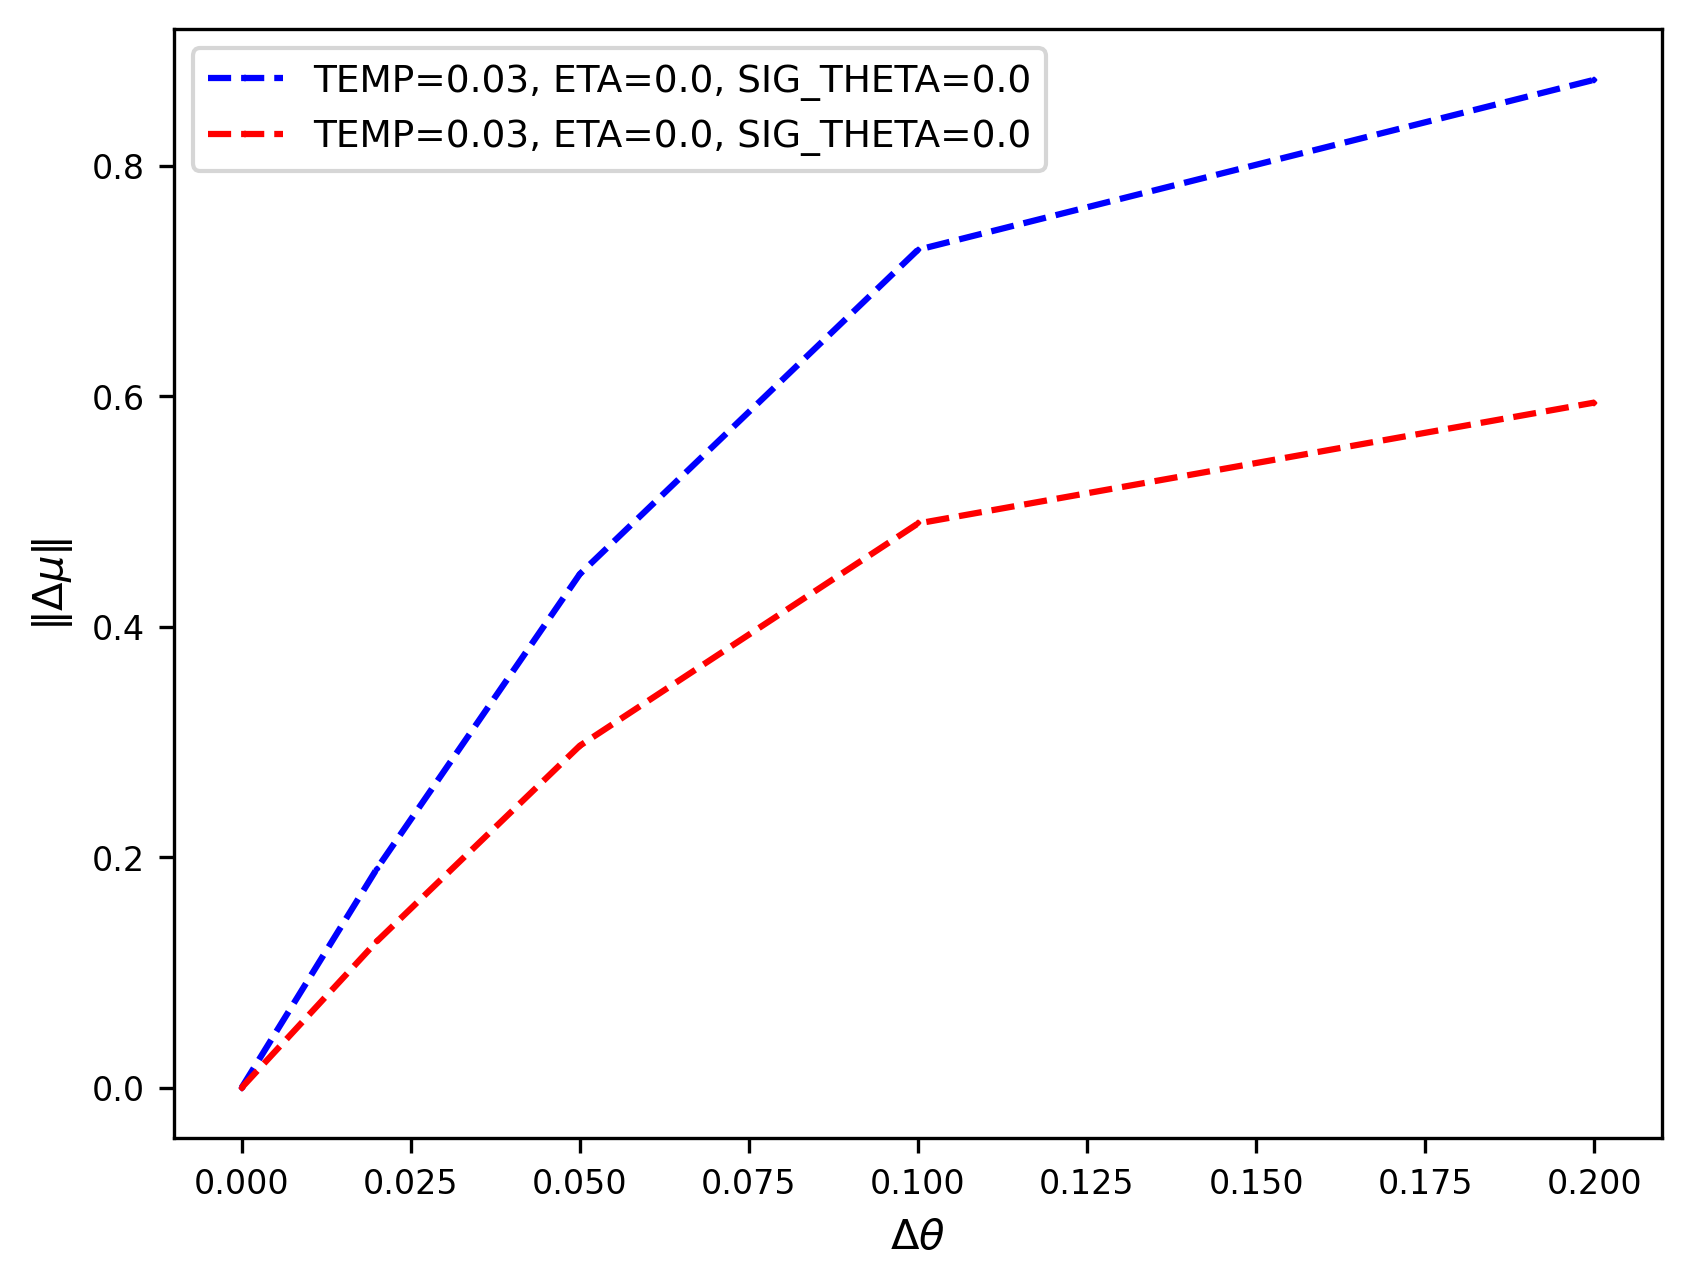

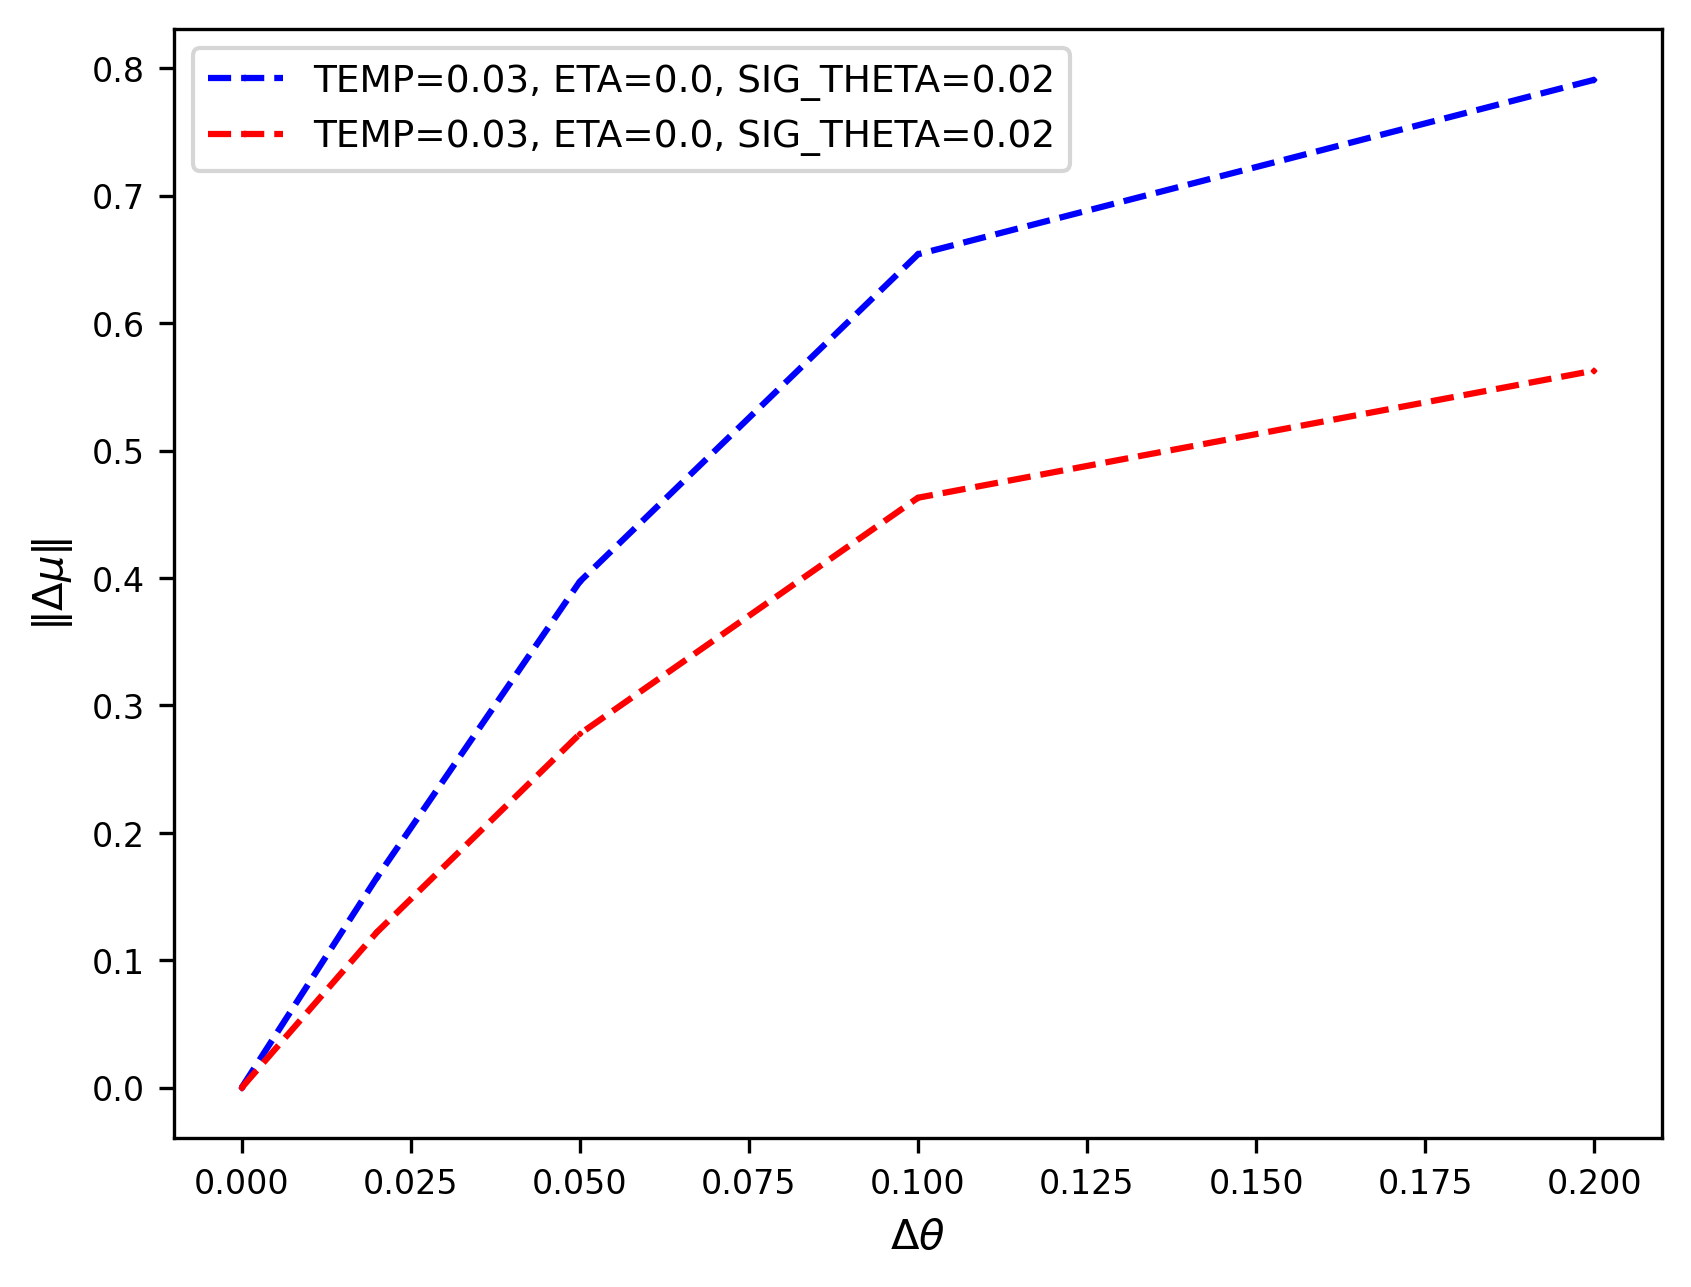

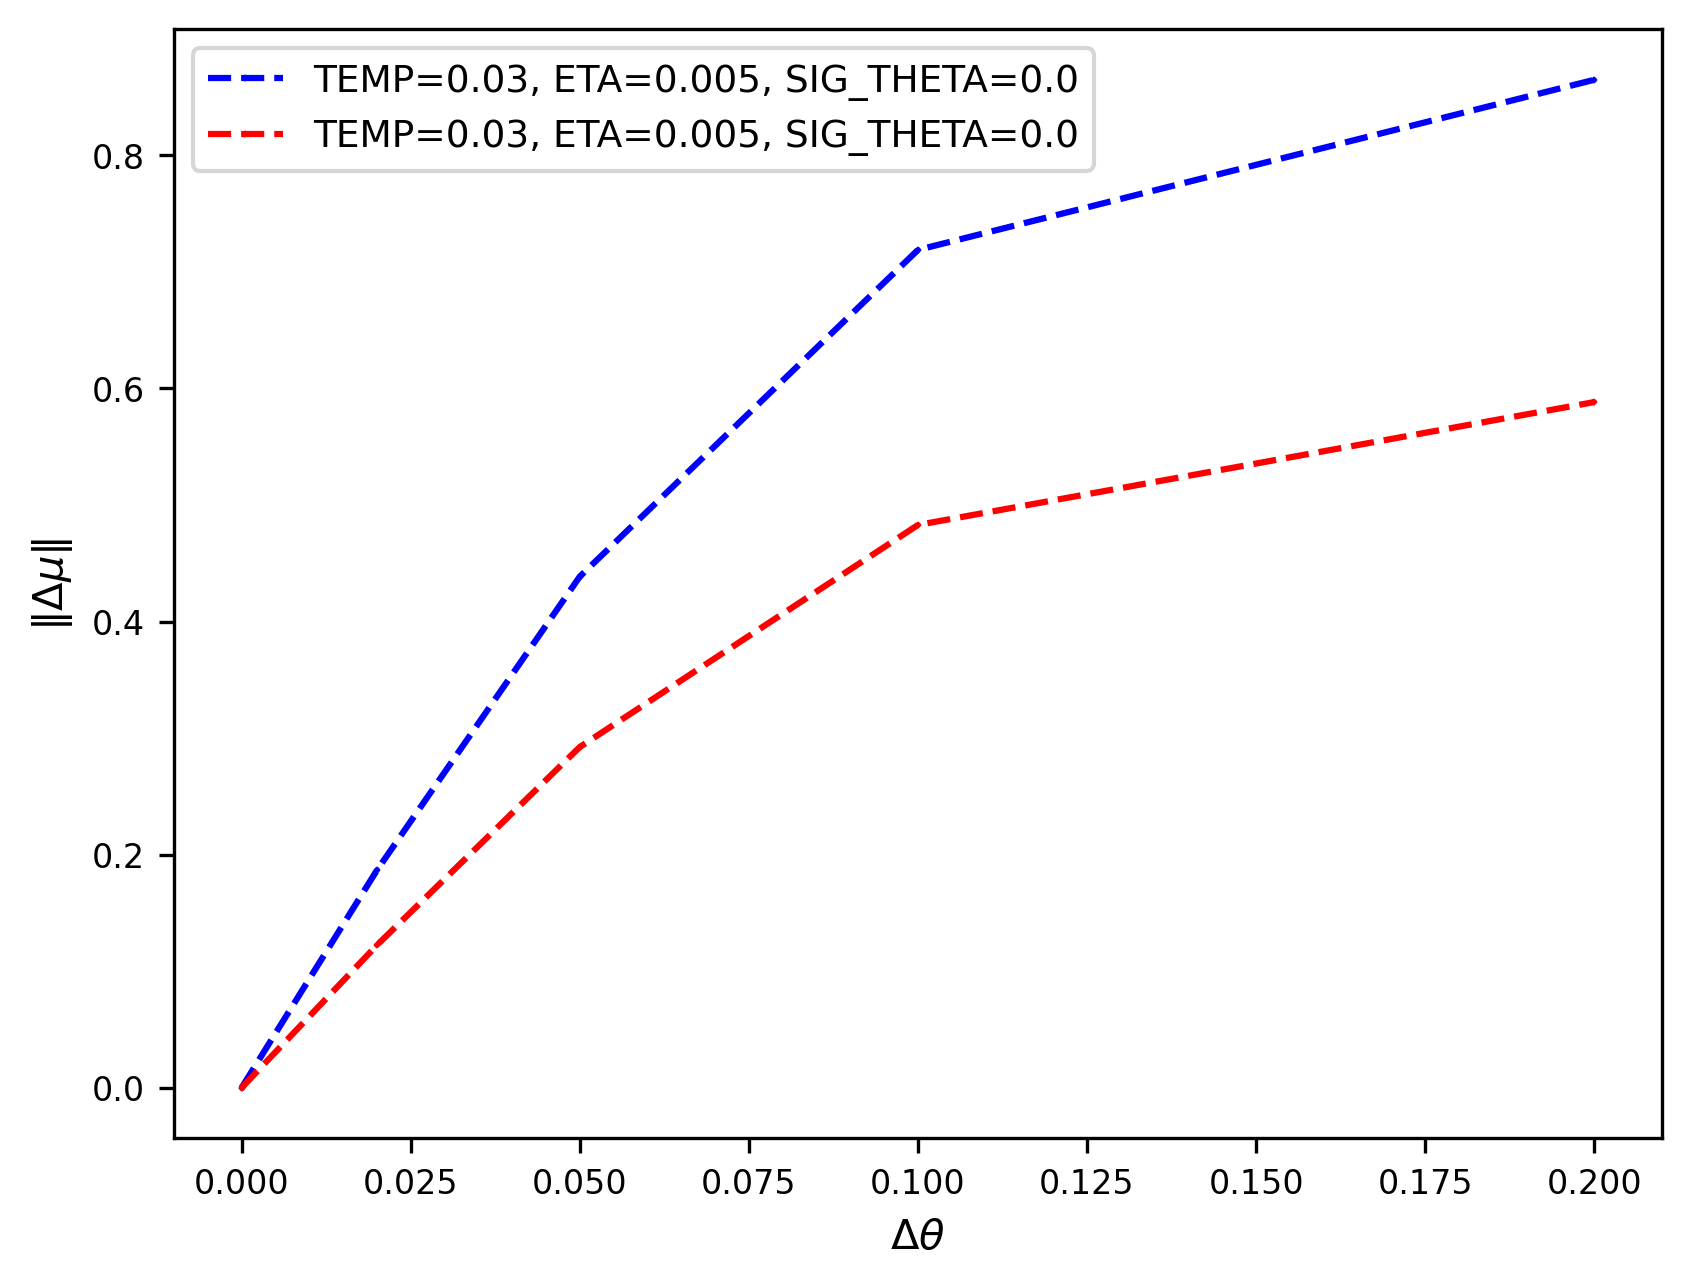

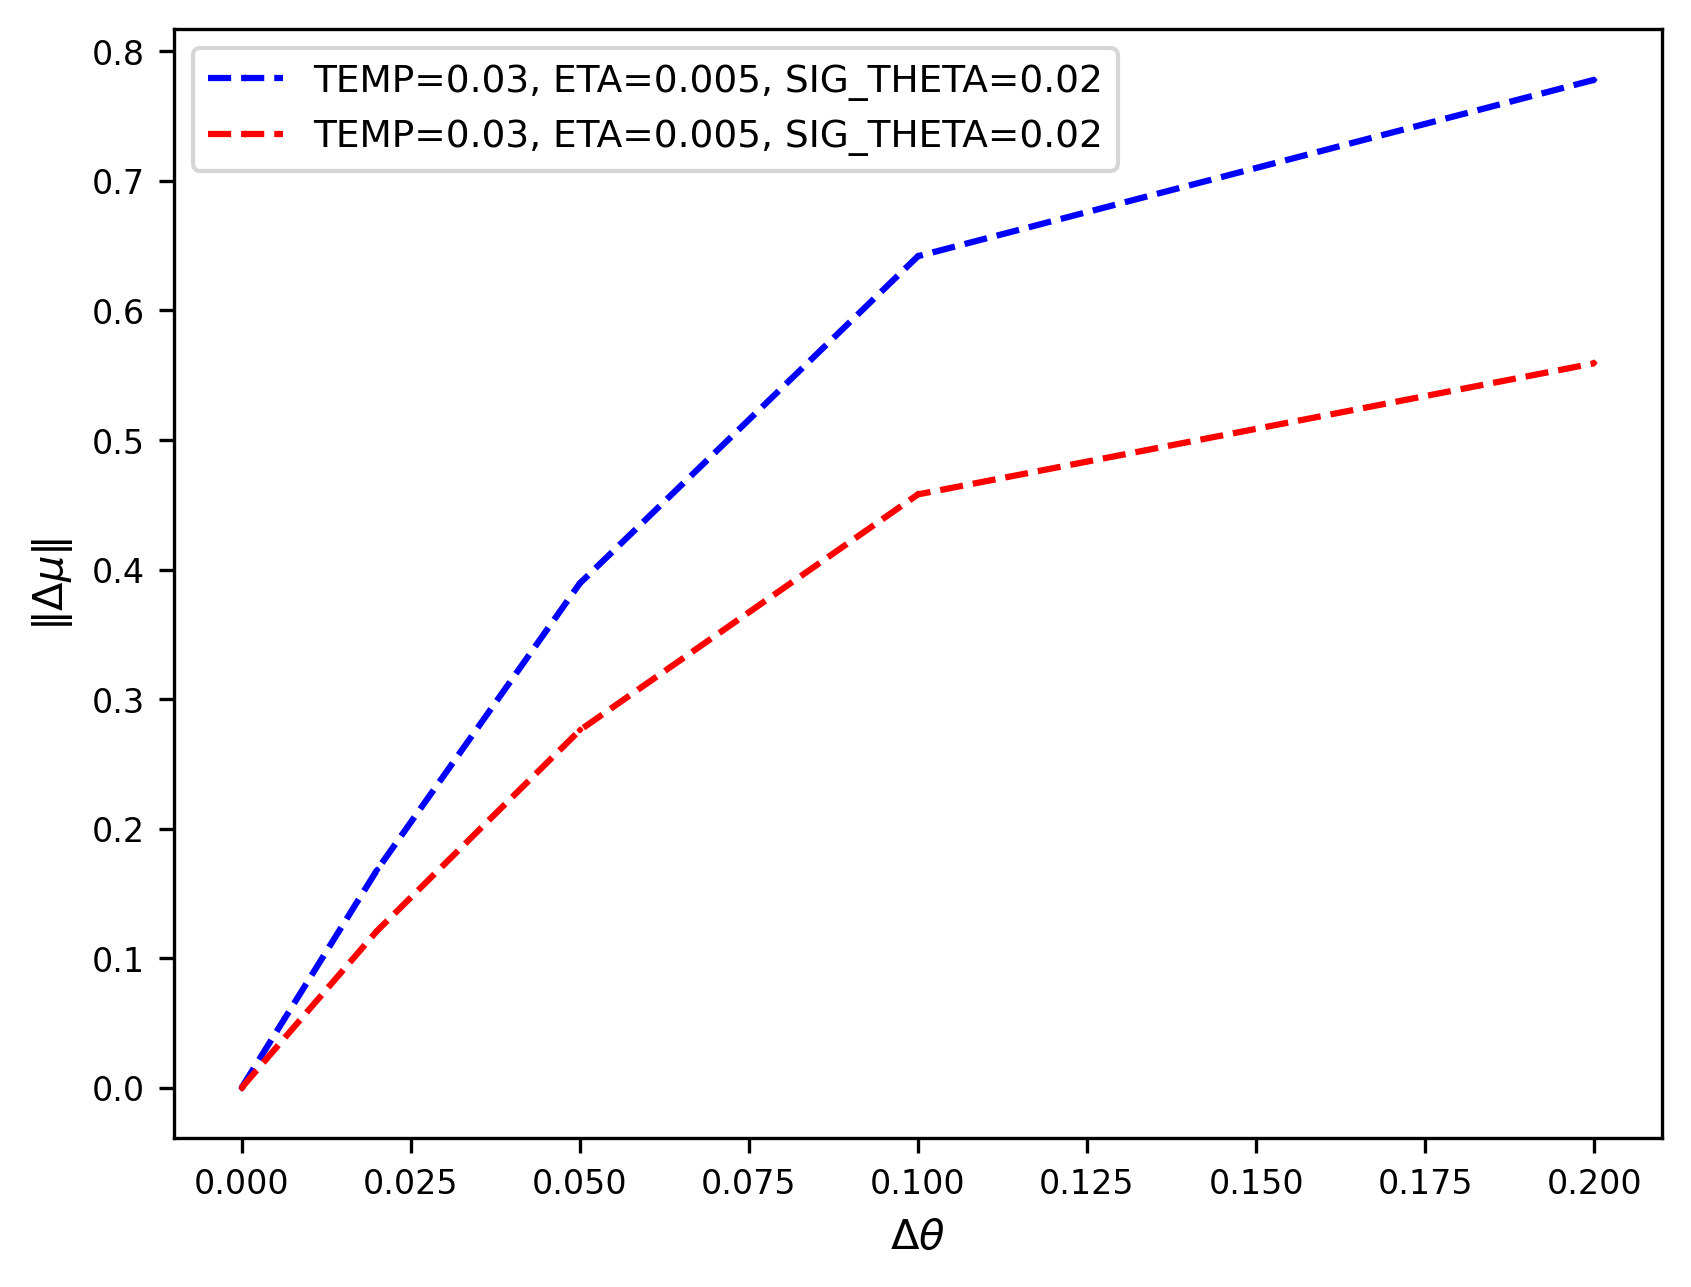

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '$\\|\\Delta \\mu\\|$ CTR/FR')

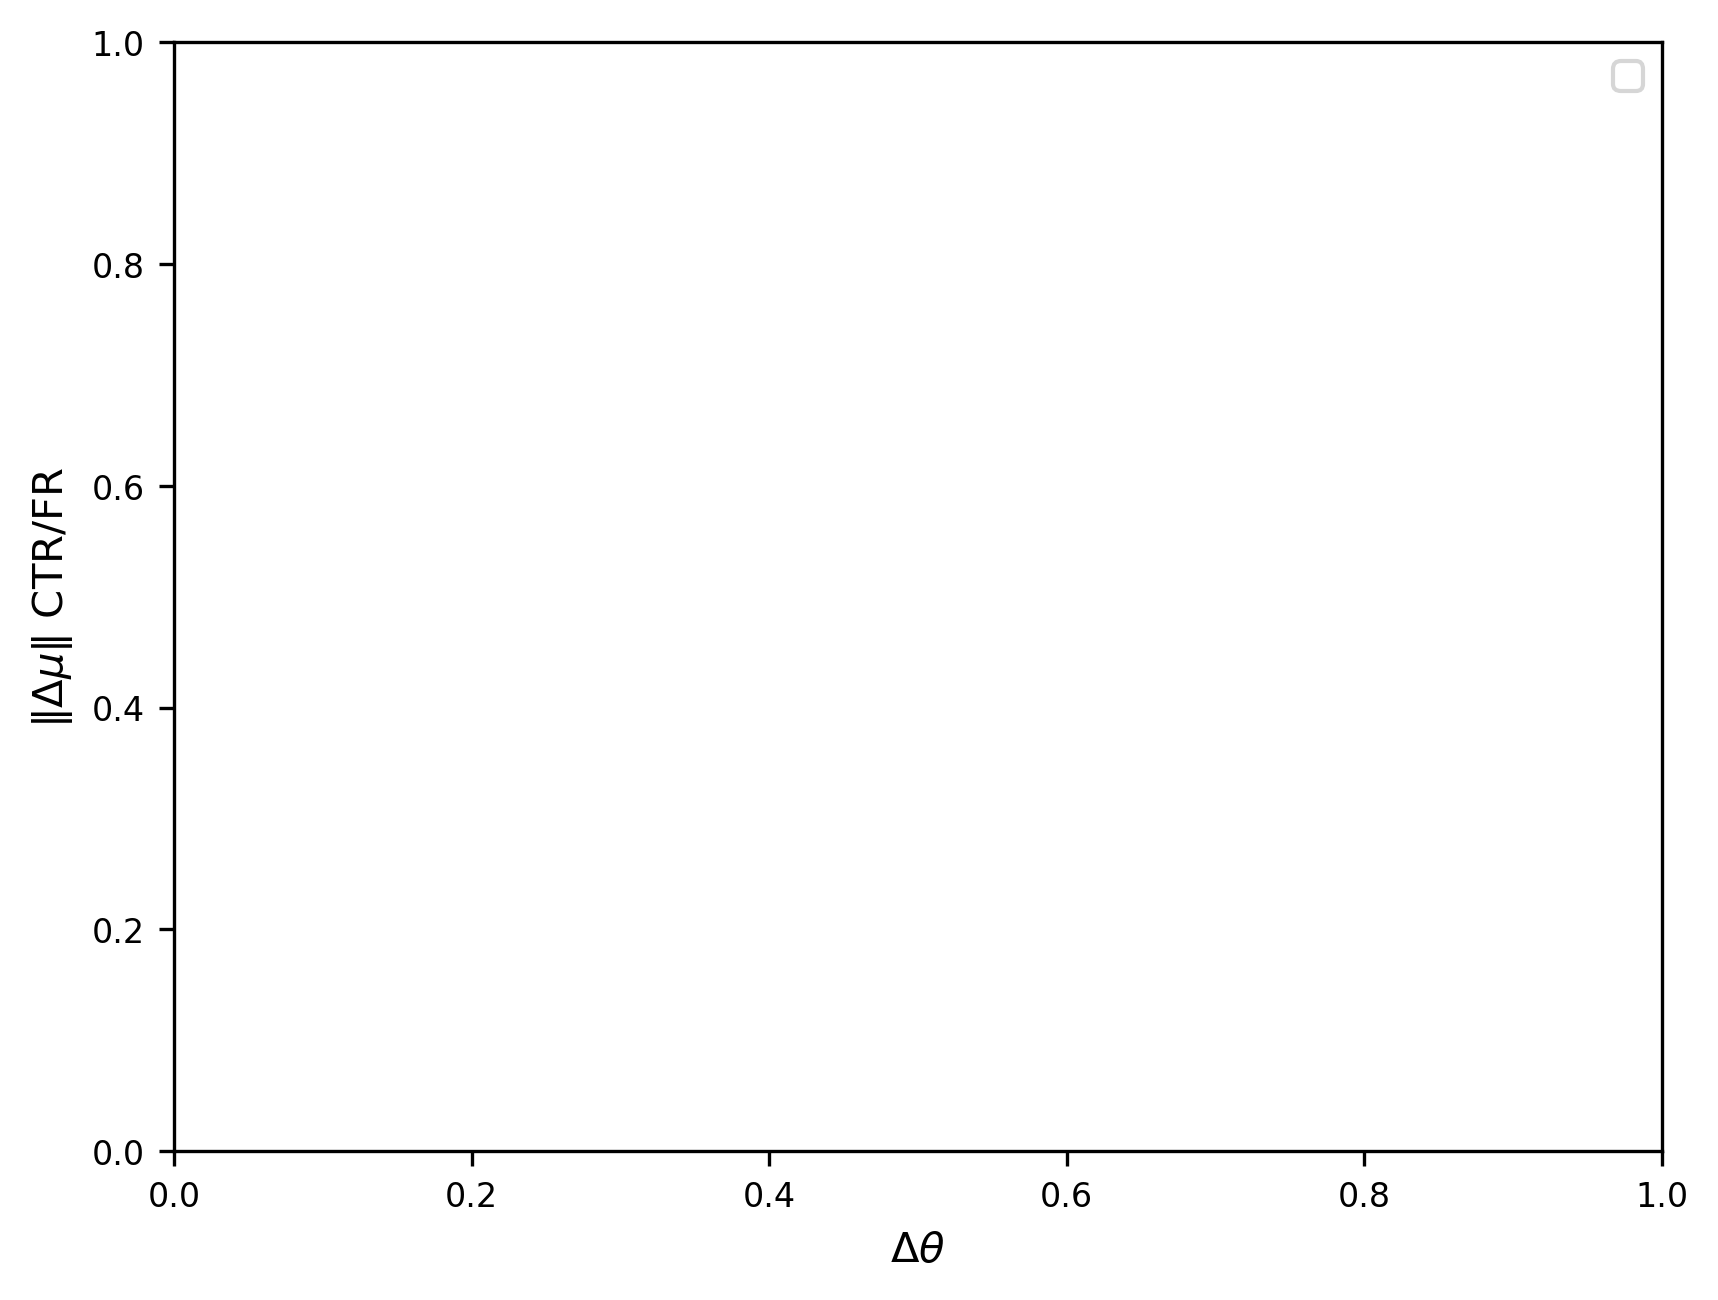

In [17]:
#Plotting \Delta mu norm for different delta theta values
for ETA in ETA_VALUES:
    for TEMP in TEMP_VALUES:
        for SIG_THETA in SIG_THETA_VALUES:
            DIR1 = 0.5
            DTHETA = []
            DMU_FR = []
            DMU_CTR = []
            for DIR2 in IDIR_VALUES:
                DTHETA.append(delta_final_ctr[TEMP_VALUES.index(TEMP),ETA_VALUES.index(ETA),SIG_THETA_VALUES.index(SIG_THETA), IDIR_VALUES.index(DIR2)])
                #For CTR
                MU1  = tensors[1,1,TEMP,ETA,SIG_THETA][:,:,0, IDIR_VALUES.index(DIR1)].mean(axis=1)
                MU2 = tensors[1,1,TEMP,ETA,SIG_THETA][:,:,0, IDIR_VALUES.index(DIR2)].mean(axis=1)        
                DMU_CTR.append(np.linalg.norm(MU1 - MU2))
                #For FR
                MU1  = tensors[0.64,1.27,TEMP,ETA,SIG_THETA][:,:,0, IDIR_VALUES.index(DIR1)].mean(axis=1)
                MU2 = tensors[0.64,1.27,TEMP,ETA,SIG_THETA][:,:,0, IDIR_VALUES.index(DIR2)].mean(axis=1)        
                DMU_FR.append(np.linalg.norm(MU1 - MU2))
            plt.plot(DTHETA, np.array(DMU_CTR), 'x--',color = 'blue',label=f"TEMP={TEMP}, ETA={ETA}, SIG_THETA={SIG_THETA}")
            plt.plot(DTHETA, np.array(DMU_FR), 'x--',color = 'red',label=f"TEMP={TEMP}, ETA={ETA}, SIG_THETA={SIG_THETA}")
            plt.legend()
            plt.xlabel(r"$\Delta \theta$")
            plt.ylabel(r"$\|\Delta \mu\|$")
            plt.show()
# plt.axhline(y=1, color='gray', linestyle='--', lw=0.8)
plt.legend()
plt.xlabel(r"$\Delta \theta$")
plt.ylabel(r"$\|\Delta \mu\|$ CTR/FR")
            # plt.plot(DTHETA, DMU_FR, 's--',label=f"TEMP={TEMP}, ETA={ETA}, SIG_THETA={SIG_THETA}")

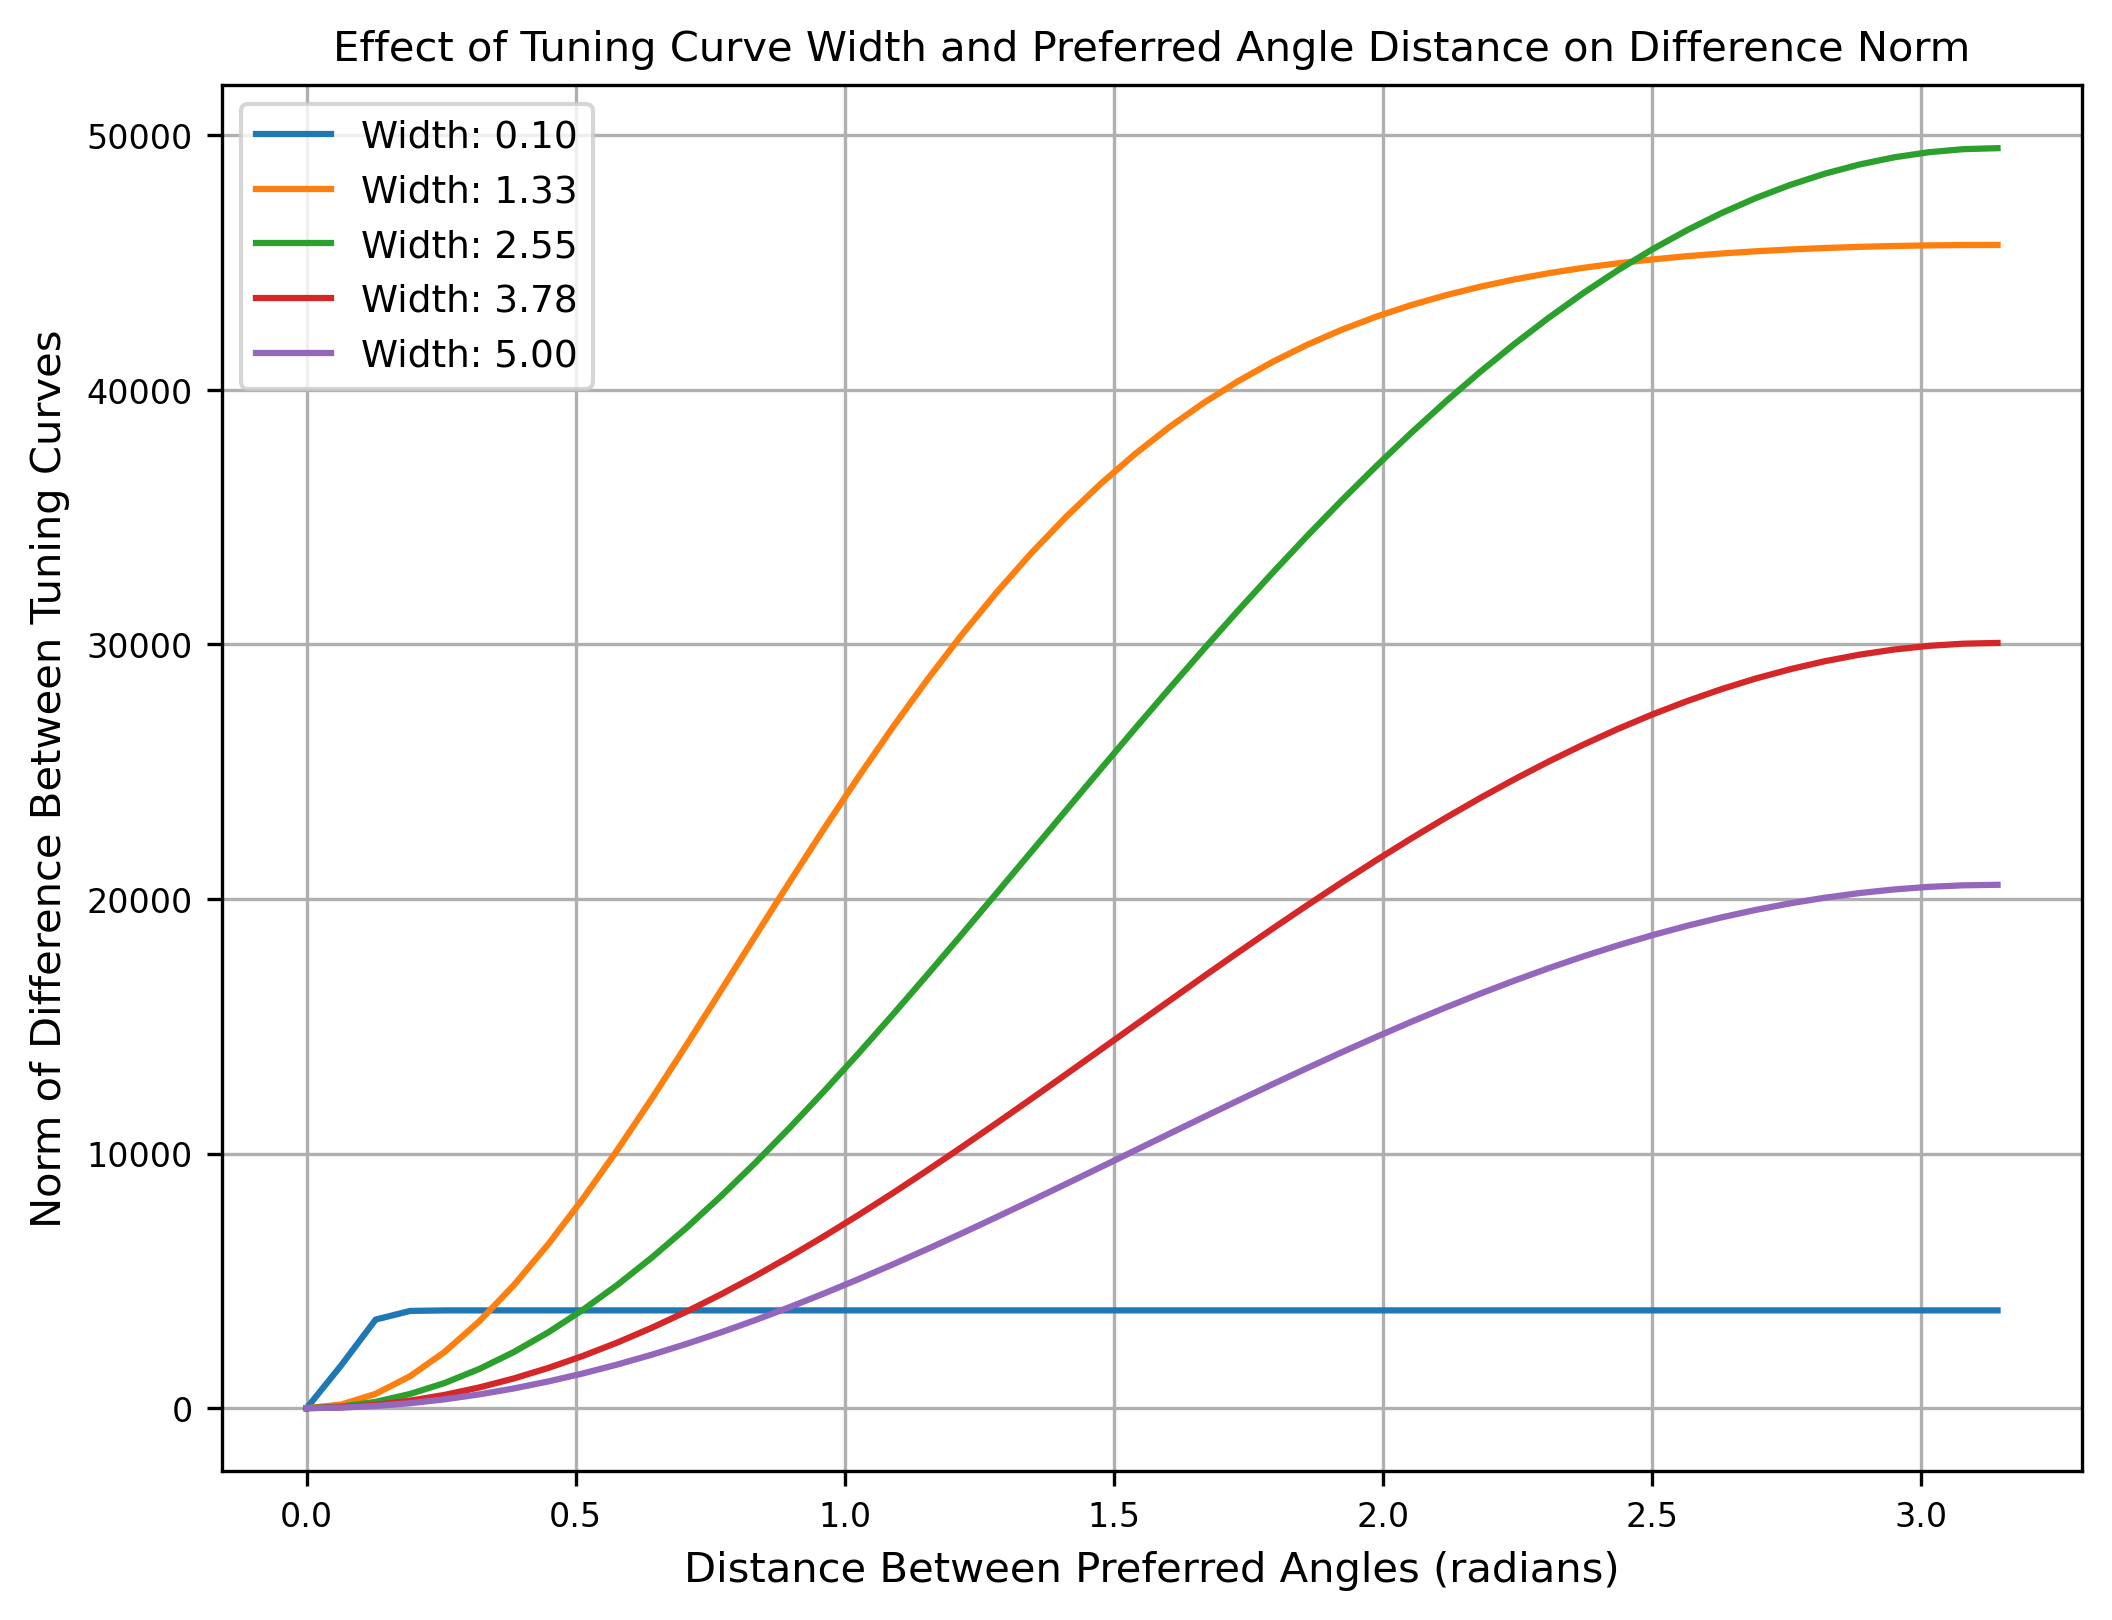

In [ ]:
# Generate two von-mises tuning curves using numpy and matplotlib

def von_mises_tuning_curve(
    angles: np.ndarray,
    preferred_angle: float,
    width: float,
    baseline: float,
    amplitude: float,
) -> np.ndarray:
    """
    Generate a von Mises tuning curve.
    
    Parameters:
    - angles: array of angles (in radians)
    - preferred_angle: preferred angle of the neuron (in radians)
    - width: width parameter (higher values = narrower tuning)
    - baseline: baseline firing rate
    - amplitude: peak firing rate above baseline
    
    Returns:
    - firing_rates: array of firing rates corresponding to input angles
    """
    # convert width to kappa   
    kappa = np.log(0.5)/(np.cos(width/2.0)-1)
    return baseline + amplitude * np.exp(kappa * (np.cos(angles - preferred_angle) - 1))

#hyperparameters
num_neurons = 100
width = 2.0  # width parameter
baseline = 5.0  # baseline firing rate
amplitude = 20.0  # peak firing rate above baseline



def comparison(centre2, width):
    tuning_curve_1 = von_mises_tuning_curve(
        angles=np.linspace(0, 2 * np.pi, 360),
        preferred_angle=0.0,
        width=width,
        baseline=baseline,
        amplitude=amplitude,
    )
    tuning_curve_2 = von_mises_tuning_curve(
        angles=np.linspace(0, 2 * np.pi, 360),
        preferred_angle=centre2,
        width=width,
        baseline=baseline,
        amplitude=amplitude,
    )
    difference_curve = tuning_curve_1 - tuning_curve_2
    square_norm = np.linalg.norm(difference_curve)**2
    return square_norm



# How does the width of the tuning curve and the distance between preferred angles 
# affect the norm of the difference?



widths = np.linspace(0.1, 5.0, 5)
#relationship between fwhm and kappa
centre_distances = np.linspace(0, np.pi, 50)
norms = np.zeros((len(widths), len(centre_distances)))
for i, width in enumerate(widths):
    for j, centre2 in enumerate(centre_distances):
        norms[i, j] = comparison(centre2, width)


# I want to see if I increase the width,
#  whether the norm of the difference increases or decreases 
# for short and long distances between preferred angles


plt.figure(figsize=(8, 6))
for i, width in enumerate(widths):
    plt.plot(centre_distances, norms[i, :], label=f'Width: {width:.2f}')
plt.xlabel('Distance Between Preferred Angles (radians)')
plt.ylabel('Norm of Difference Between Tuning Curves')
plt.title('Effect of Tuning Curve Width and Preferred Angle Distance on Difference Norm')
plt.legend()
plt.grid()
plt.show()




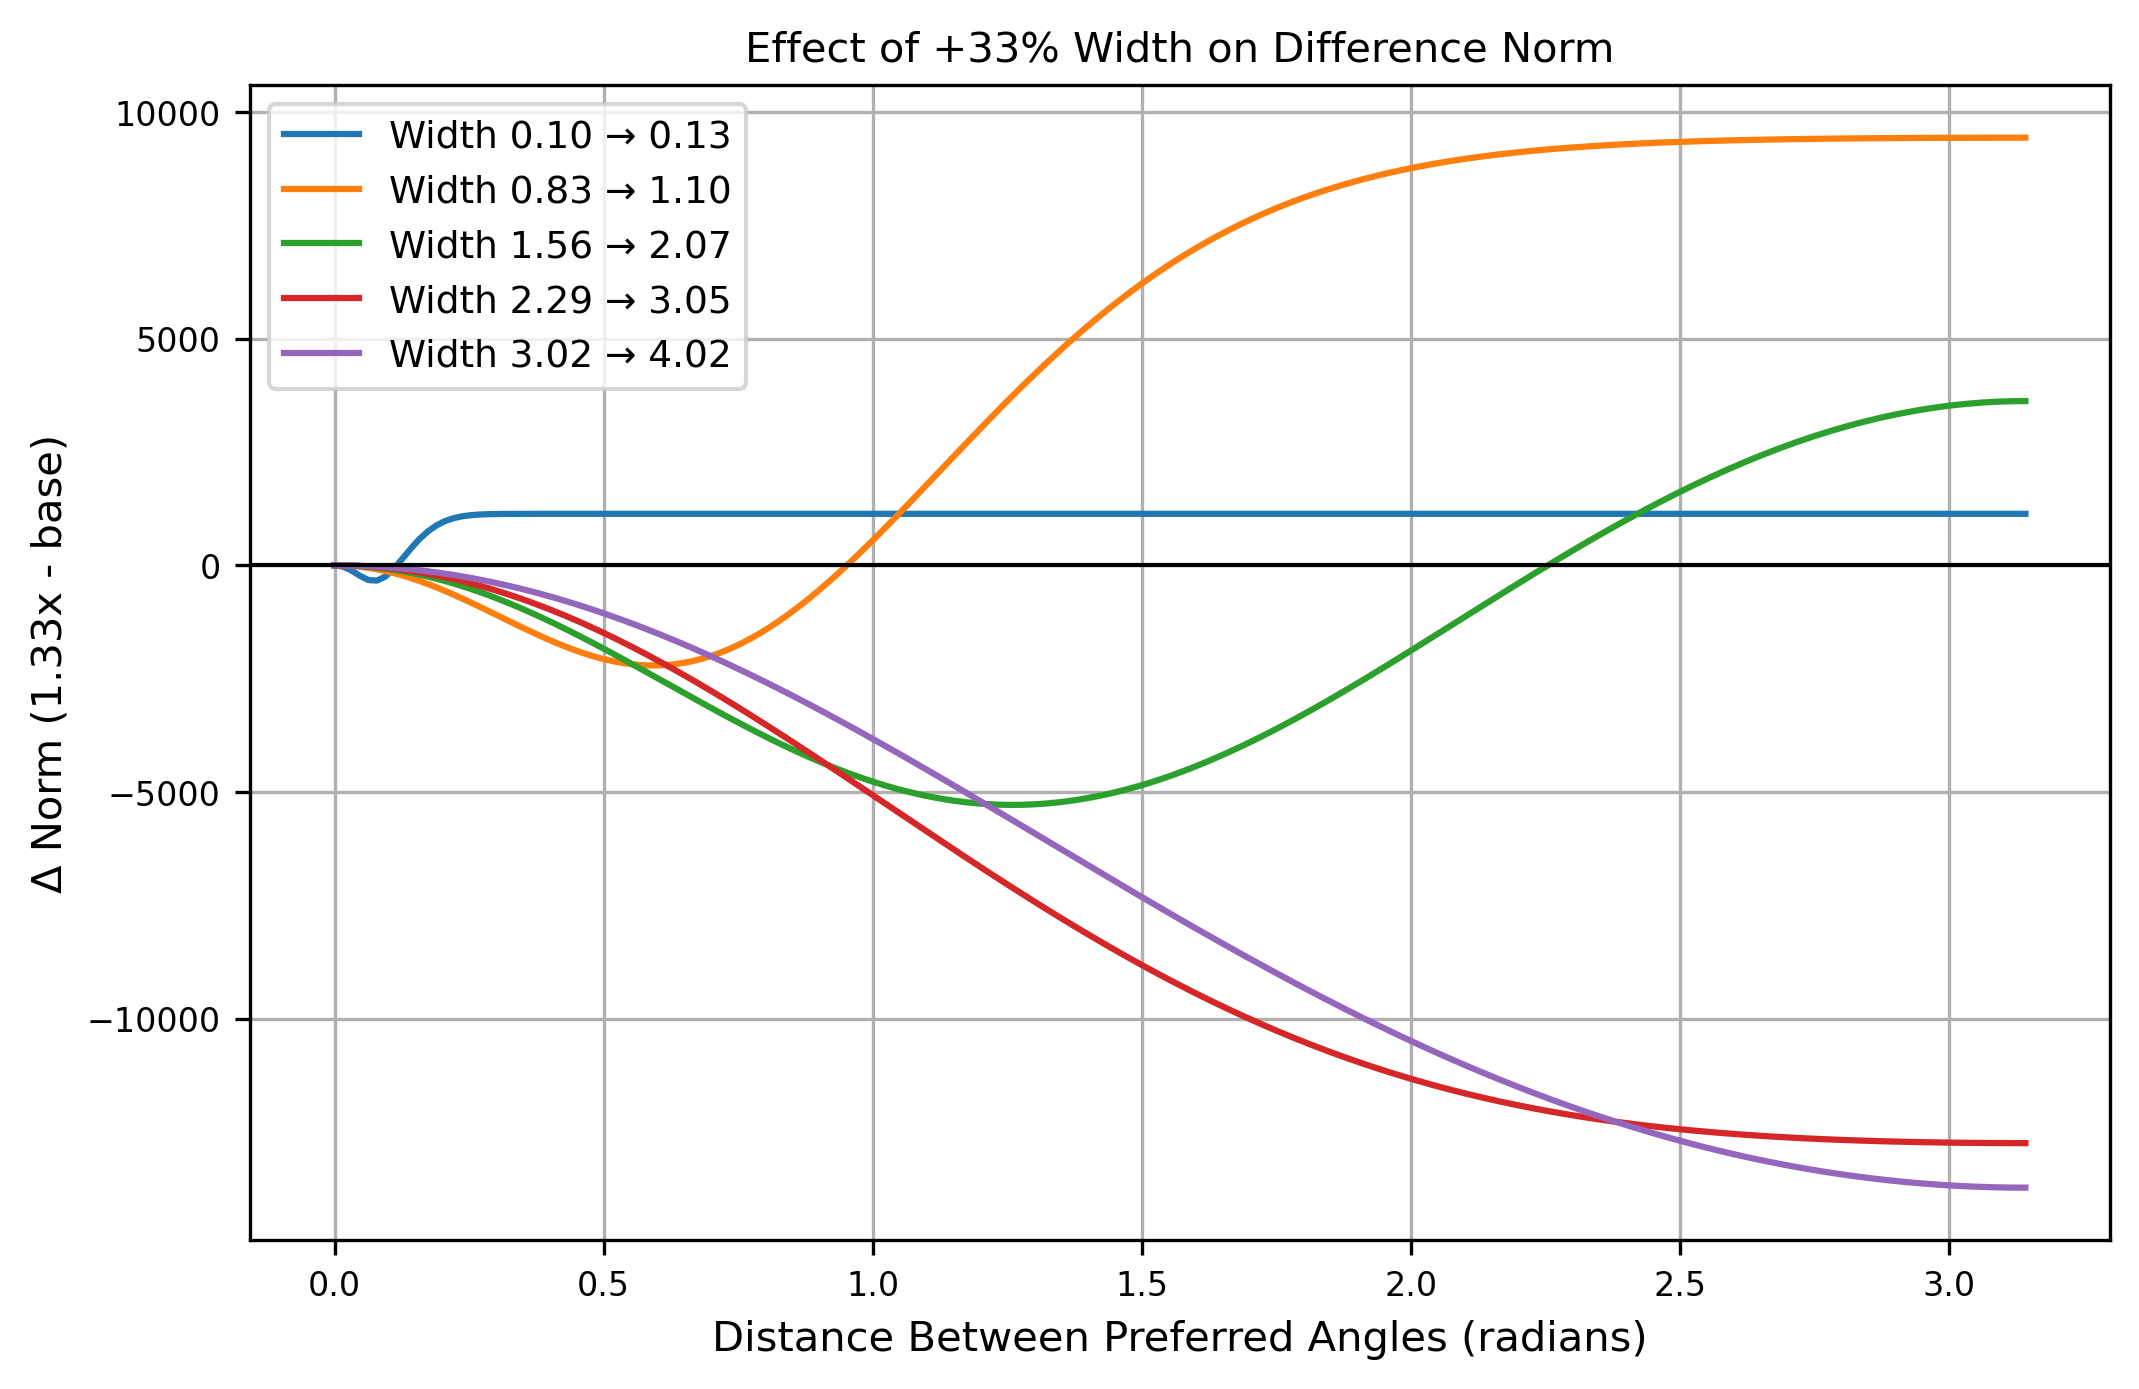

Width | Mean Δ short | Mean Δ long
0.10 | 730.558282 | 1135.405604
0.83 | -938.798395 | 9418.208555
1.56 | -706.962497 | 3162.213116
2.29 | -557.570970 | -12689.342038
3.02 | -393.421212 | -13498.802677


In [34]:
# define distance grid
centre_distances = np.linspace(0, np.pi, 200)

# define short/long bands (adjust if needed)
short_max = np.pi / 6    # 30 degrees
long_min  = 5 * np.pi / 6  # 150 degrees

short_mask = centre_distances <= short_max
long_mask  = centre_distances >= long_min

def norm_vs_distance(width):
    return np.array([comparison(c, width) for c in centre_distances])
widths = np.linspace(0.1, 3.02, 5)
# compute and report for each width
results = []
plt.figure(figsize=(8, 5))
for width in widths:
    width_inc = width * 1.33
    norm_base = norm_vs_distance(width)
    norm_inc = norm_vs_distance(width_inc)
    delta = norm_inc - norm_base

    mean_short = delta[short_mask].mean()
    mean_long = delta[long_mask].mean()
    results.append((width, mean_short, mean_long))

    plt.plot(centre_distances, delta, label=f'Width {width:.2f} → {width_inc:.2f}')

plt.axhline(0, color="k", linewidth=1)
plt.xlabel('Distance Between Preferred Angles (radians)')
plt.ylabel('Δ Norm (1.33x - base)')
plt.title('Effect of +33% Width on Difference Norm')
plt.legend()
plt.grid()
plt.show()

# print summary table
print("Width | Mean Δ short | Mean Δ long")
for width, mean_short, mean_long in results:
    print(f"{width:.2f} | {mean_short:.6f} | {mean_long:.6f}")


# Per Mode SNR

In [36]:
TEMP = TEMP_VALUES[0]
ETA = ETA_VALUES[1]
SIG_THETA = SIG_THETA_VALUES[1]

def compute_snr_per_mode(state, averaging, dmu):
    neurons, generations, trials, idirs = state.shape
    overlaps_array = np.full((neurons,trials), np.nan)
    evals_array = np.full((neurons,trials), np.nan)
    # average State over blocks
    average_size = averaging
    n_blocks = generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep
    state = state[:, :cut, :, :]
    state = state.reshape(neurons, n_blocks, average_size, trials, idirs).mean(axis=2)

    

    main_dir = 0
    other_dir = dmu
    for trial in range(trials):
        mean = state[:,:,trial,:].mean(axis=(1))  # neurons x idirs
        dmu = mean[:,main_dir] - mean[:,other_dir]
        covariance = np.cov(state[:,:,trial,main_dir])
        evals, evecs = np.linalg.eigh(covariance)
        order = np.argsort(evals)[::-1]
        evecs = evecs[:,order]
        evals = evals[order]
        snr_total = dmu.T @ np.linalg.pinv(covariance) @ dmu
        for mode_idx in range(neurons):
            overlaps_array[mode_idx, trial] = (dmu @ evecs[:,mode_idx])**2 
            evals_array[mode_idx, trial] = evals[mode_idx]
        # overlaps_array[:,trial] = np.sort(overlaps_array[:,trial])[::-1]
    return overlaps_array[:,:], evals_array[:,:], snr_total

WINDOW = BLOCK_SIZE*5
dmu = 1
ctr_overlaps, ctr_evals, ctr_snr = compute_snr_per_mode(tensors[1,1,TEMP,ETA,SIG_THETA], averaging=WINDOW, dmu= dmu)
fr_overlaps, fr_evals, fr_snr = compute_snr_per_mode(tensors[0.64,1.27,TEMP,ETA,SIG_THETA], averaging=WINDOW, dmu=dmu)
print(f"CTR/FR SNR: {ctr_snr/fr_snr:.3f}")
print(f"CTR SNR: {ctr_snr:.3f}, FR SNR: {fr_snr:.3f}")

CTR/FR SNR: 1.131
CTR SNR: 12.653, FR SNR: 11.187


Text(0.5, 1.0, 'Overlap of Δμ with Eigenmodes vs Eigenvalue')

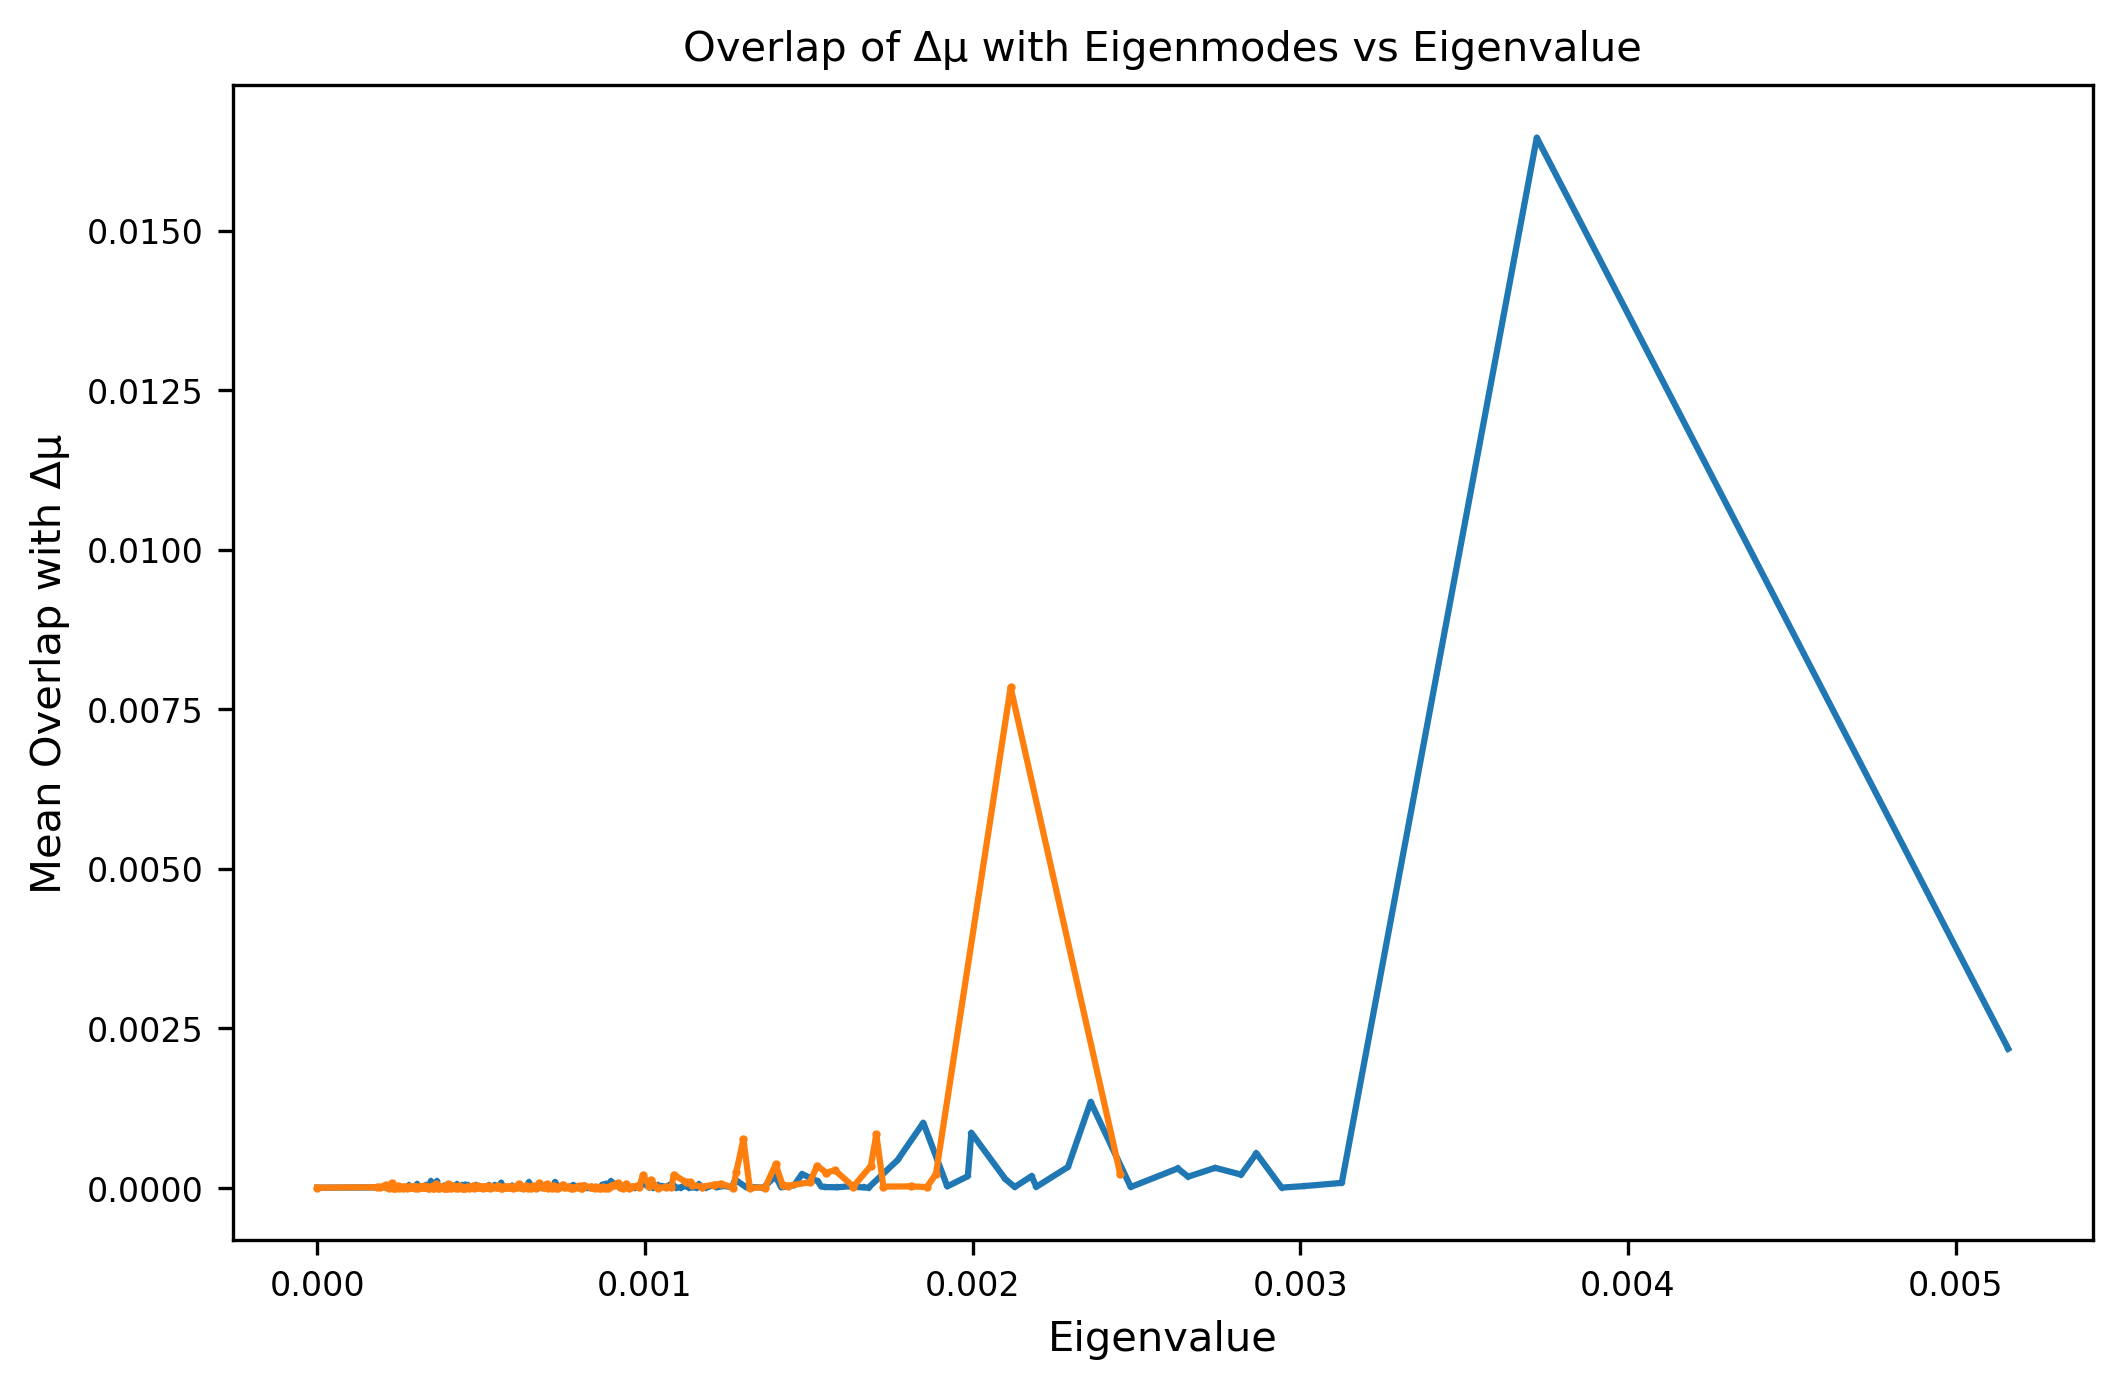

In [37]:
# Normal Overlap Eigenvalue Plot
plt.figure(figsize=(8, 5))
plt.plot(ctr_evals.mean(axis=1), ctr_overlaps.mean(axis=1), 'x-', label='CTR')
plt.plot(fr_evals.mean(axis=1), fr_overlaps.mean(axis=1), 'o-', label='FR')
plt.xlabel('Eigenvalue')
plt.ylabel('Mean Overlap with Δμ')
plt.title('Overlap of Δμ with Eigenmodes vs Eigenvalue')

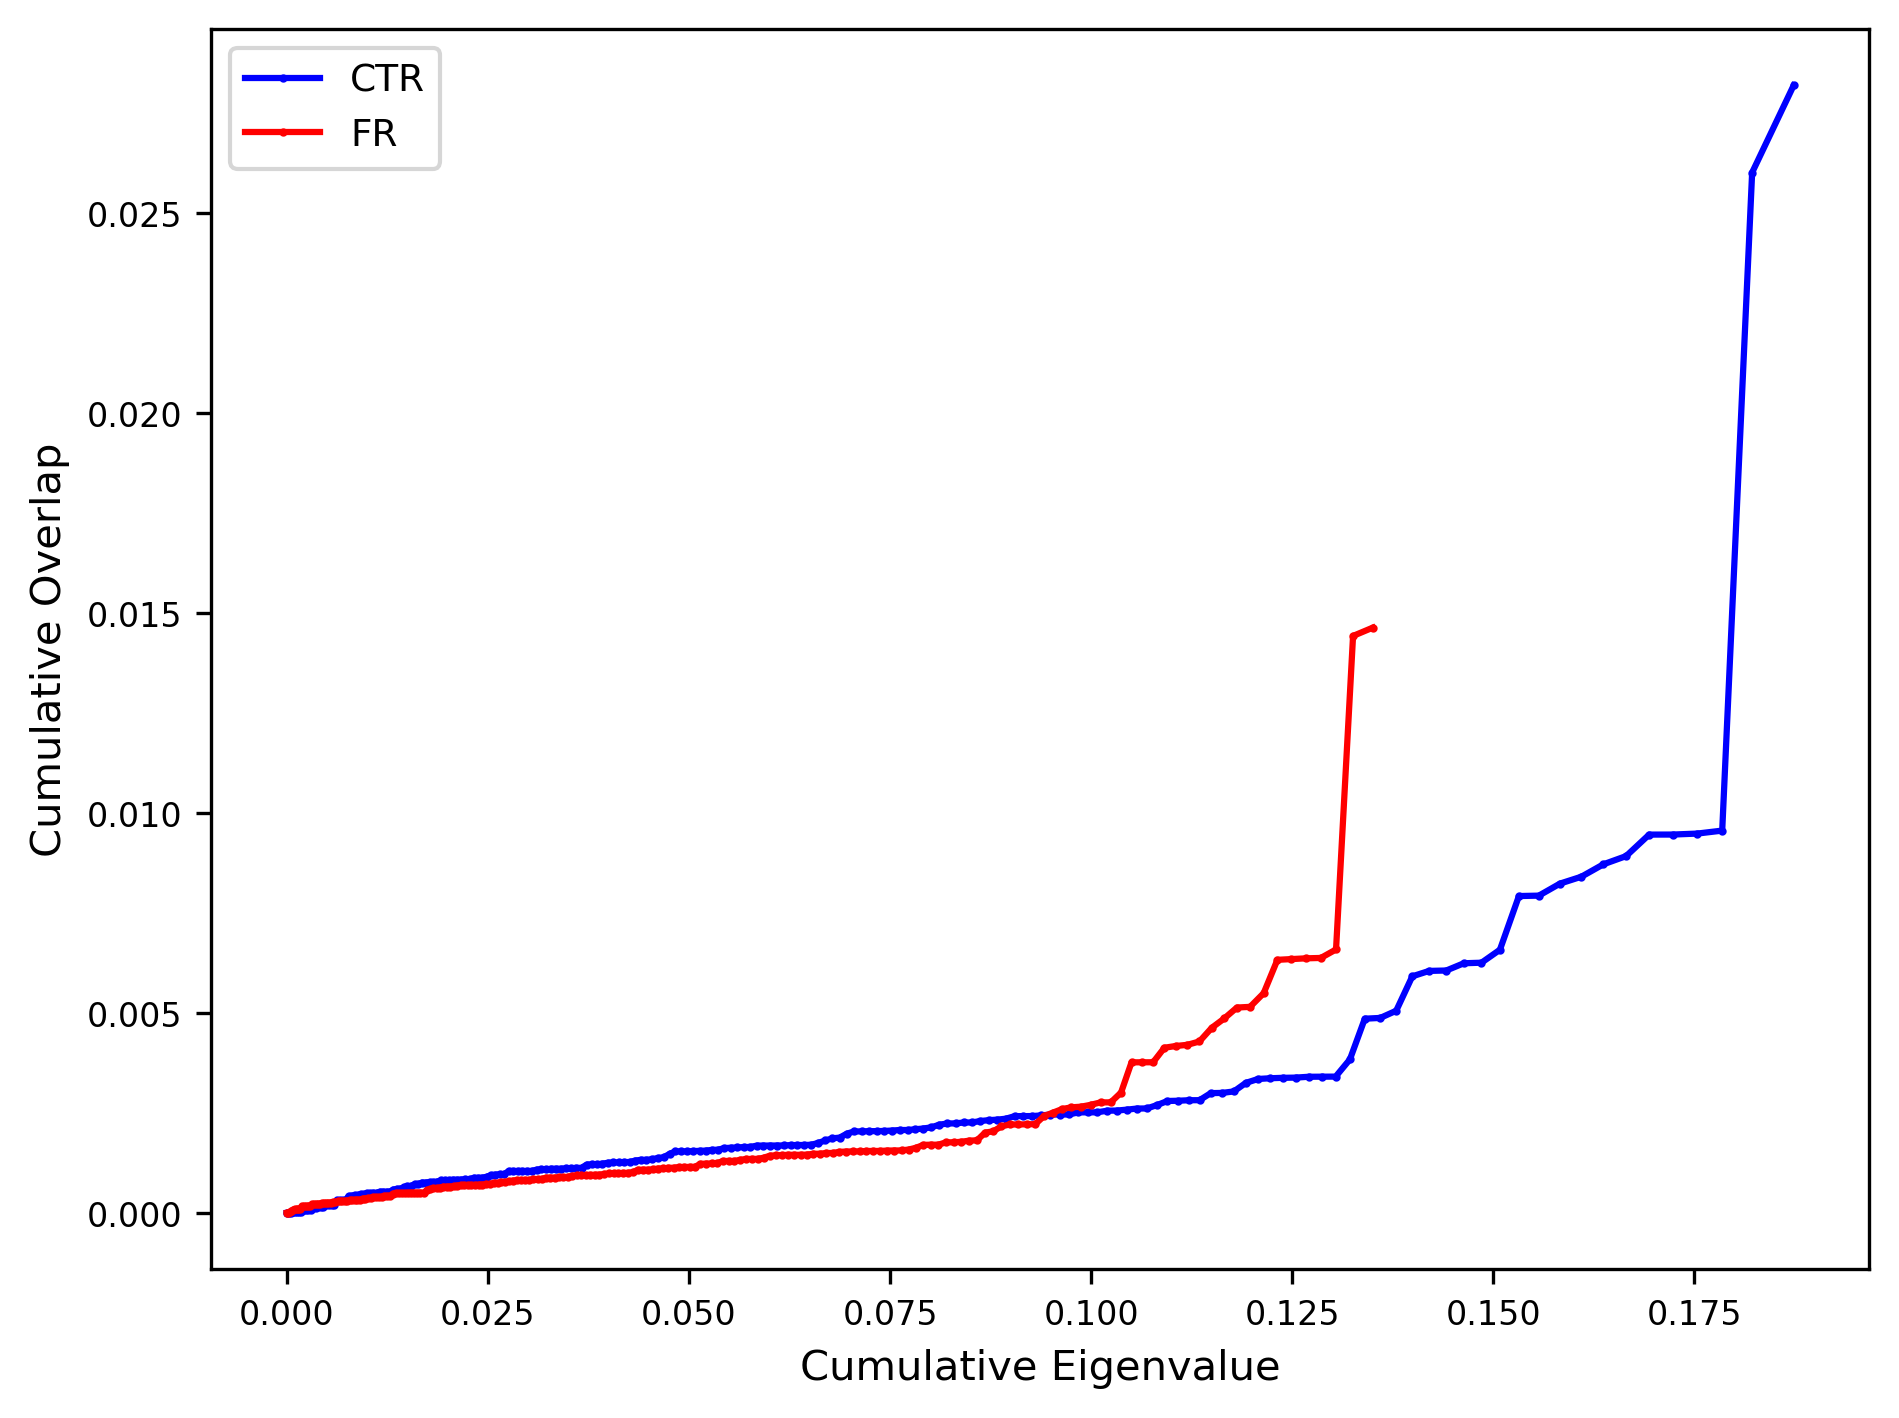

In [38]:
# Cumulative Overlap vs Cumulative Eigenvalue Plot

num_remove = 0

ctr_overlap_cumsum = np.cumsum(ctr_overlaps[num_remove:,:].mean(axis=1)[::-1], axis=0)
ctr_evals_cumsum = np.cumsum(ctr_evals[num_remove:,:].mean(axis=1)[::-1], axis=0) #ctr_evals[num_remove:,:].mean(axis=1)[::-1]

fr_overlap_cumsum = np.cumsum(fr_overlaps[num_remove:,:].mean(axis=1)[::-1], axis=0)
fr_evals_cumsum = np.cumsum(fr_evals[num_remove:,:].mean(axis=1)[::-1], axis=0)# fr_evals[num_remove:,:].mean(axis=1)[::-1]#

plt.plot(ctr_evals_cumsum, ctr_overlap_cumsum, 'o-', label="CTR", color="blue")
plt.plot(fr_evals_cumsum, fr_overlap_cumsum, 'o-',label="FR", color="red")
# plt.plot([0,(fr_evals_cumsum[-3])], [0,(fr_evals_cumsum[-3])], 'k--', label="Unity Line", lw=2)
plt.ylabel("Cumulative Overlap")
plt.xlabel("Cumulative Eigenvalue")
# plt.xlim(0,0.01)
# plt.ylim(0,0.01)
plt.legend()
plt.tight_layout()

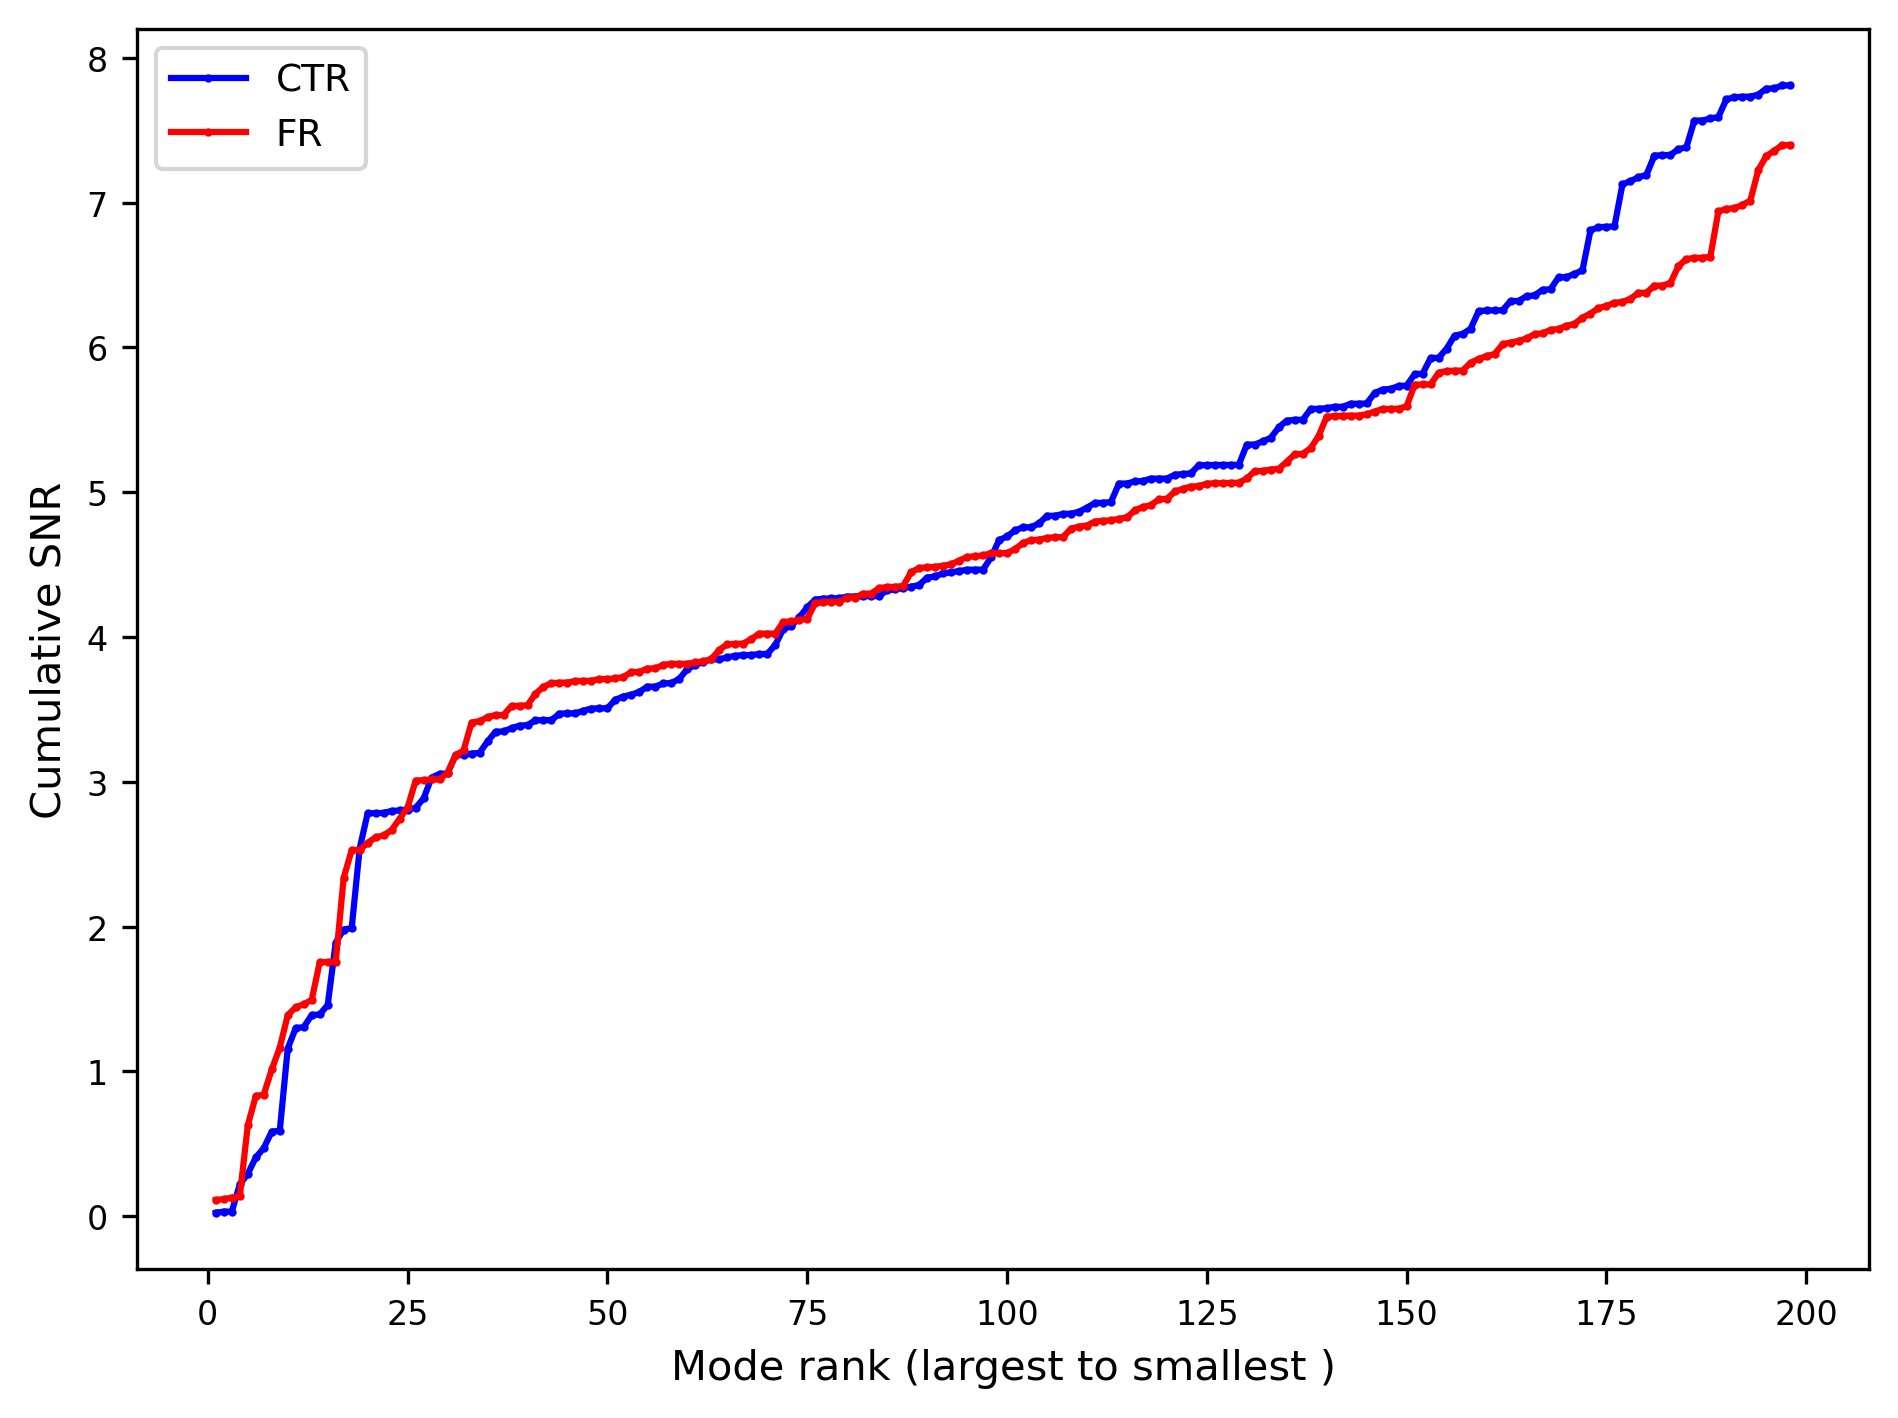

In [42]:
ctr_snr = ctr_overlaps / ctr_evals
fr_snr = fr_overlaps / fr_evals

ctr_snr_mean = ctr_snr.mean(axis=1)
fr_snr_mean = fr_snr.mean(axis=1)

# Modes are sorted by descending eigenvalue above, so reverse for smallest->largest.
ctr_cum_snr = np.cumsum(ctr_snr_mean[2:])
fr_cum_snr = np.cumsum(fr_snr_mean[2:])
x_axis = np.arange(1, ctr_cum_snr.shape[0] + 1)
plt.plot(x_axis, ctr_cum_snr, 'o-', label="CTR", color="blue")
plt.plot(x_axis, fr_cum_snr, 'o-', label="FR", color="red")
plt.xlabel("Mode rank (largest to smallest )")
# plt.ylim(0,0.1)
plt.ylabel("Cumulative SNR")
plt.legend()
plt.tight_layout()

# Verification of Covariance

In [74]:
def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))

    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile


def calculate_R_slow(state, N, T,ampar,rin,equilibrium_change):
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = 0.1

    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)

    Gen = state.shape[1]
    R_matrices = np.zeros((Gen//equilibrium_change, N, N))
    for gen in range(Gen//equilibrium_change):
        start_gen = gen*equilibrium_change
        end_gen = (gen+1)*equilibrium_change
        state_time = state[:, start_gen:end_gen]
        # mean_firing_rate = state_time.mean(axis=1)
        # D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate)/T)
        # R_mat = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix*rin

        # D = np.diag(mean_firing_rate * (1 - mean_firing_rate))/T
        # c = rin * ampar
        # A = np.eye(N) - c * (D @ weights)
        # Rb = np.linalg.solve(A, D)
        # one = np.ones((N, 1))
        # u = (one.T @ Rb)               # shape (1,N)
        # v = (Rb @ one)                 # shape (N,1)
        # denom = float(one.T @ v)       # scalar
        # Rb_cons = Rb - (v @ u) / denom
        # Rb_cons = Rb_cons * rin
        # plt.plot(np.linalg.eigvalsh(Rb_cons), np.linalg.eigvalsh(np.cov(state_time)/T),'.')
        # plt.show()
        # dx = get_bump(idir=0.505, num_neurons=N, sigma_input=0.1, amplitude=.01)- get_bump(idir=0.5, num_neurons=N, sigma_input=0.1, amplitude=0.01)
        covz = np.cov(state_time)
        # print(np.linalg.norm((covz@dx))/np.linalg.norm(dx))
        R_matrices[gen,:,:] = rin*covz/T# Rb_cons
    Mean_R_matrix = R_matrices.mean(axis=0)

    return Mean_R_matrix

def calculate_R_fast(state, N, T, ampar,rin,yes_t):
    # STATE is N x GEn
    # Define R matrix which is (1-DJ)^-1 D/T    where D matrix is \partial(\sigma(h))/\partial h
    threshold_active_fraction = THRESH_ACTIVE_FRACTION_VALUES[0]
    indices = np.arange(N)
    i_matrix = indices[:, None]      # shape (N, 1)
    j_matrix = indices[None, :]      # shape (1, N)
    diff = np.abs(i_matrix - j_matrix)
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    weights = (diff <= threshold).astype(float) / N
    np.fill_diagonal(weights, 0.0)


    mean_firing_rate = state.mean(axis=1)
    if yes_t:
        D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate))/T # DONT DIVIDE BY T HERE
    else:
        D_matrix = np.diag(mean_firing_rate * (1 - mean_firing_rate))
    # plt.plot(mean_firing_rate*(1-mean_firing_rate), label = f'T = {T}, ETA = {eta}')
    R_matrix = np.linalg.inv(np.eye(N) - rin*ampar*D_matrix @ weights) @ D_matrix#*rin
    return R_matrix

def calculate_R_fast_conserved(state, N, T, ampar, rin, yes_t):
    # Build the same W you assume in theory
    threshold_active_fraction = THRESH_ACTIVE_FRACTION_VALUES[0]
    idx = np.arange(N)
    diff = np.abs(idx[:, None] - idx[None, :])
    diff = np.minimum(diff, N - diff)
    threshold = threshold_active_fraction * N / 2.0
    W = (diff <= threshold).astype(float) / N
    np.fill_diagonal(W, 0.0)

    m = state.mean(axis=1)  # <s_i>
    if T <= 0:
        raise ValueError("Mean-field D needs T>0; for T=0 use empirical cov or treat separately.")
    if yes_t:
        D = np.diag(m * (1 - m))/T
    else:
        D = np.diag(m * (1 - m))

    c = rin * ampar
    A = np.eye(N) - c * (D @ W)

    # Base (unconstrained) response to b
    # Rb = A^{-1} D
    Rb = np.linalg.solve(A, D)

    # Enforce sum_i δm_i = 0  (activity conservation)
    one = np.ones((N, 1))
    u = (one.T @ Rb)               # shape (1,N)
    v = (Rb @ one)                 # shape (N,1)
    denom = float(one.T @ v)       # scalar
    Rb_cons = Rb - (v @ u) / denom

    # If you want response to "I" where δb = rin * δI (your earlier convention),
    # return R = Rb_cons * rin
    return Rb_cons# Rb_cons * rin


(200, 20000, 1)
(200, 20000, 1)
(200, 20000, 1)
(200, 20000, 1)


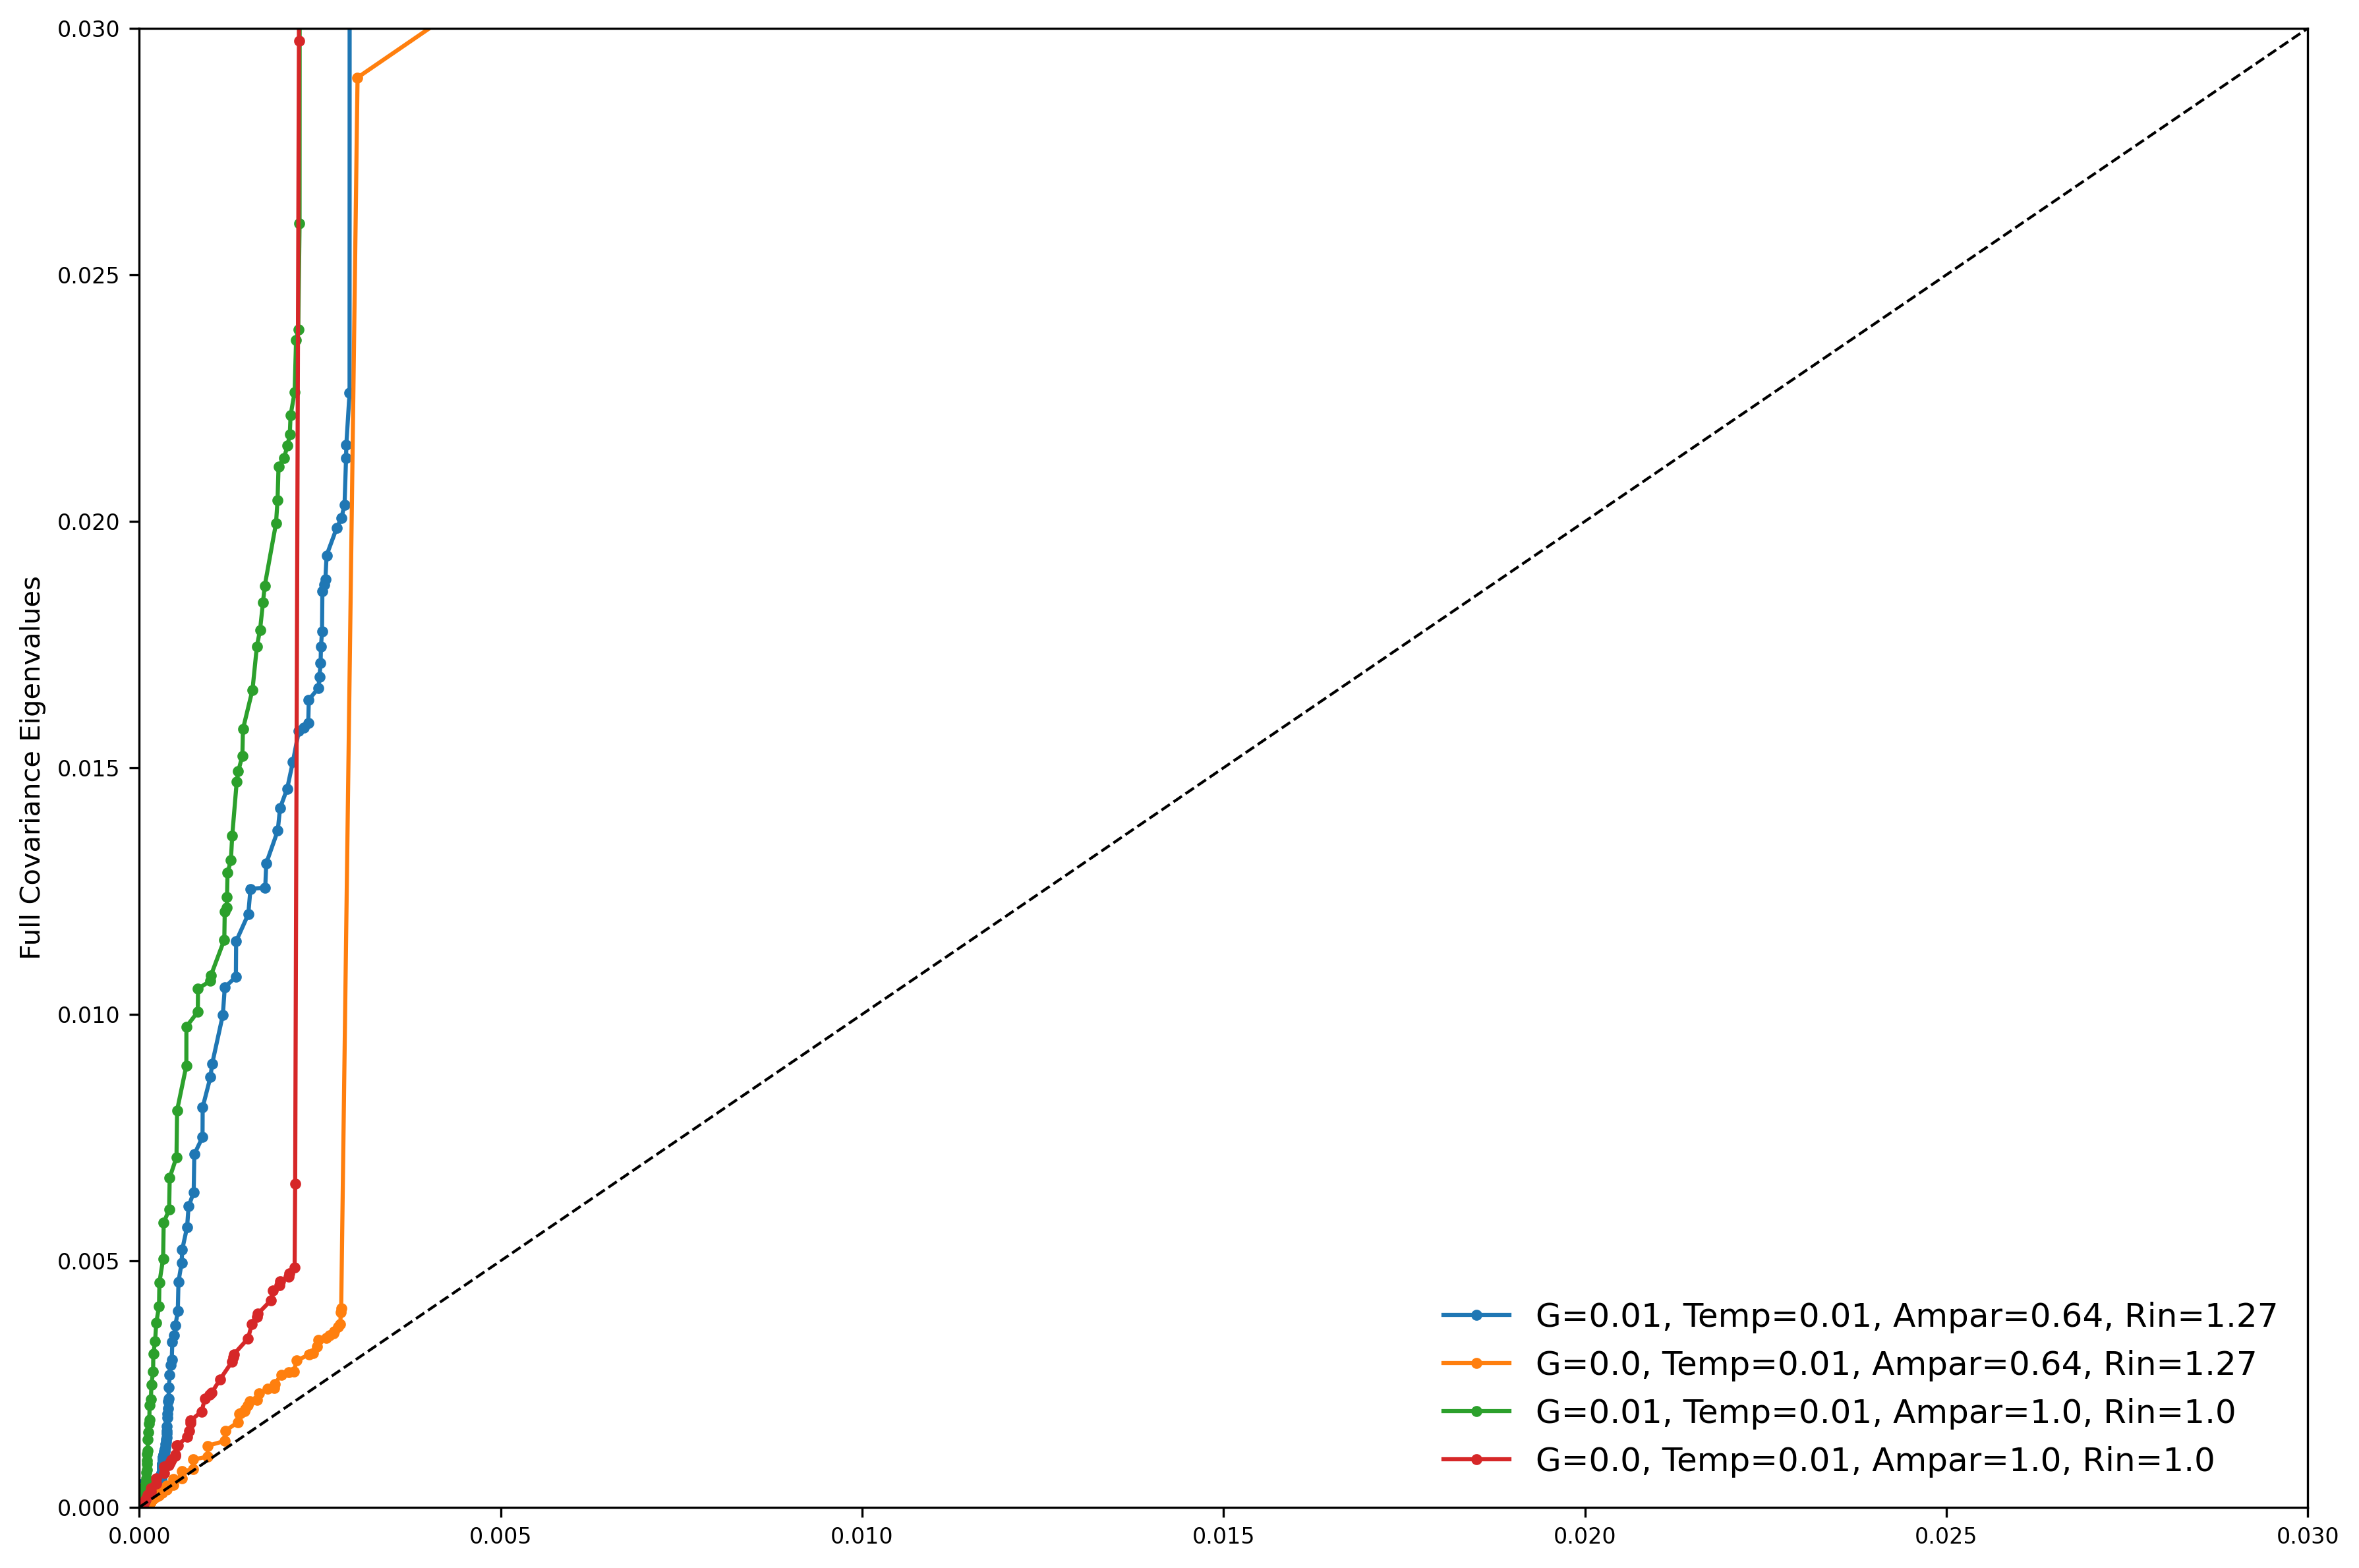

In [90]:
fig, ax = plt.subplots(figsize=(12, 8))

THETA = SIG_THETA_VALUES[0]
ETA= ETA_VALUES[0]
for AMPAR in AMPAR_VALUES:
    if AMPAR == 1.0:
        RIN = 1.0
    else:
        RIN = 1.27

    for TEMP in TEMP_VALUES[::-1]:
        for THETA in SIG_THETA_VALUES[::-1]:
            state_one_angle = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,0]
            Neurons, Generations, Trials = state_one_angle.shape
         
            
            average_size = BLOCK_SIZE//5
            n_blocks = Generations // average_size  # integer division
            cut = n_blocks * average_size             # how many generations to keep
            data_trimmed = state_one_angle[:, :cut, :]
            data_reshaped = data_trimmed.reshape(Neurons, n_blocks, average_size, Trials)
            data_avg = data_reshaped.mean(axis=2)
            data_avg = data_avg[:, :, :]
            print(data_avg.shape)
            
            
            
            state_one_angle = data_avg.reshape((Neurons, -1))
            covariance_full = np.cov(state_one_angle)
            eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)
 
            tau_gamma = BLOCK_SIZE          # you redraw gamma every 100 generations
            L = average_size         # your averaging window (25)
            f_gamma = min(1.0, tau_gamma / L)   # = 1.0 here (since 100/25 = 4)
            f_T     = 1.0 / L                   # first pass; refine with autocorr if needed
            
            # Gamma = calculate_R_slow(state_one_angle, Neurons, TEMP, AMPAR, RIN, average_size)  # this is your Γ
            Gamma = calculate_R_fast(state_one_angle, Neurons, TEMP, AMPAR, RIN, yes_t = True)  # this is your Γ
            Sigma_pred = f_T*TEMP*Gamma/(AMPAR*RIN) #+ 0.5*f_gamma*(THETA*AMPAR*RIN)**2 * (Gamma @ Gamma.T) # predicted covariance from theory

            # Chi_sym = 0.5 * (Gamma + Gamma.T)                                     # enforce symmetry
            # Sigma_pred =Gamma*f_T+Gamma@Gamma.T*f_gamma
            # Sigma_pred = (AMPAR*RIN)**2 * (THETA**2) * (Gamma @ Gamma.T)
            # Sigma_pred = (TEMP/ RIN) * f_T * Chi_sym + (AMPAR**2) * (THETA**2) * f_gamma * (Gamma @ Gamma.T)
            # Sigma_pred = TEMP*Chi_sym + ETA**2*(Gamma @ Gamma.T)

            pred_full = np.linalg.eigvalsh(Sigma_pred)   # symmetric -> use eigvalsh
            ax.plot(pred_full,eigenvalues_full, 'o-', markersize=3, label=f'G={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_ylabel("Full Covariance Eigenvalues")
# ax.set_xlabel(r"($\sigma_\gamma w \lambda_\Gamma)^2 + T*\lambda_\Gamma/r$   Matrix Eigenvalues")
# how to set x and y lim to be within main cluster of points and ignore outliers?
plt.xlim(0.,0.03)
plt.ylim(0.,0.03)  
# plt.ylim(0,0.001)
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,0.5)
plt.legend(fontsize=12, frameon=False)
fig.tight_layout()
plt.show()

# Verification of Signal Vector

/tmp/ipykernel_838760/876628422.py:103: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(one.T @ v)       # scalar


-6.938893903907228e-18 -5.9604645e-08
AMPAR: 0.64 RIN: 1.27 TEMP: 1e-05 THETA: 0.0 idir2: 0.505
Norm delta mu: 0.18401400744915009, Norm delta mu estimate: 0.012221337697978629
-3.469446951953614e-17 0.0
AMPAR: 1.0 RIN: 1.0 TEMP: 1e-05 THETA: 0.0 idir2: 0.505
Norm delta mu: 0.17936231195926666, Norm delta mu estimate: 0.019526987300993483


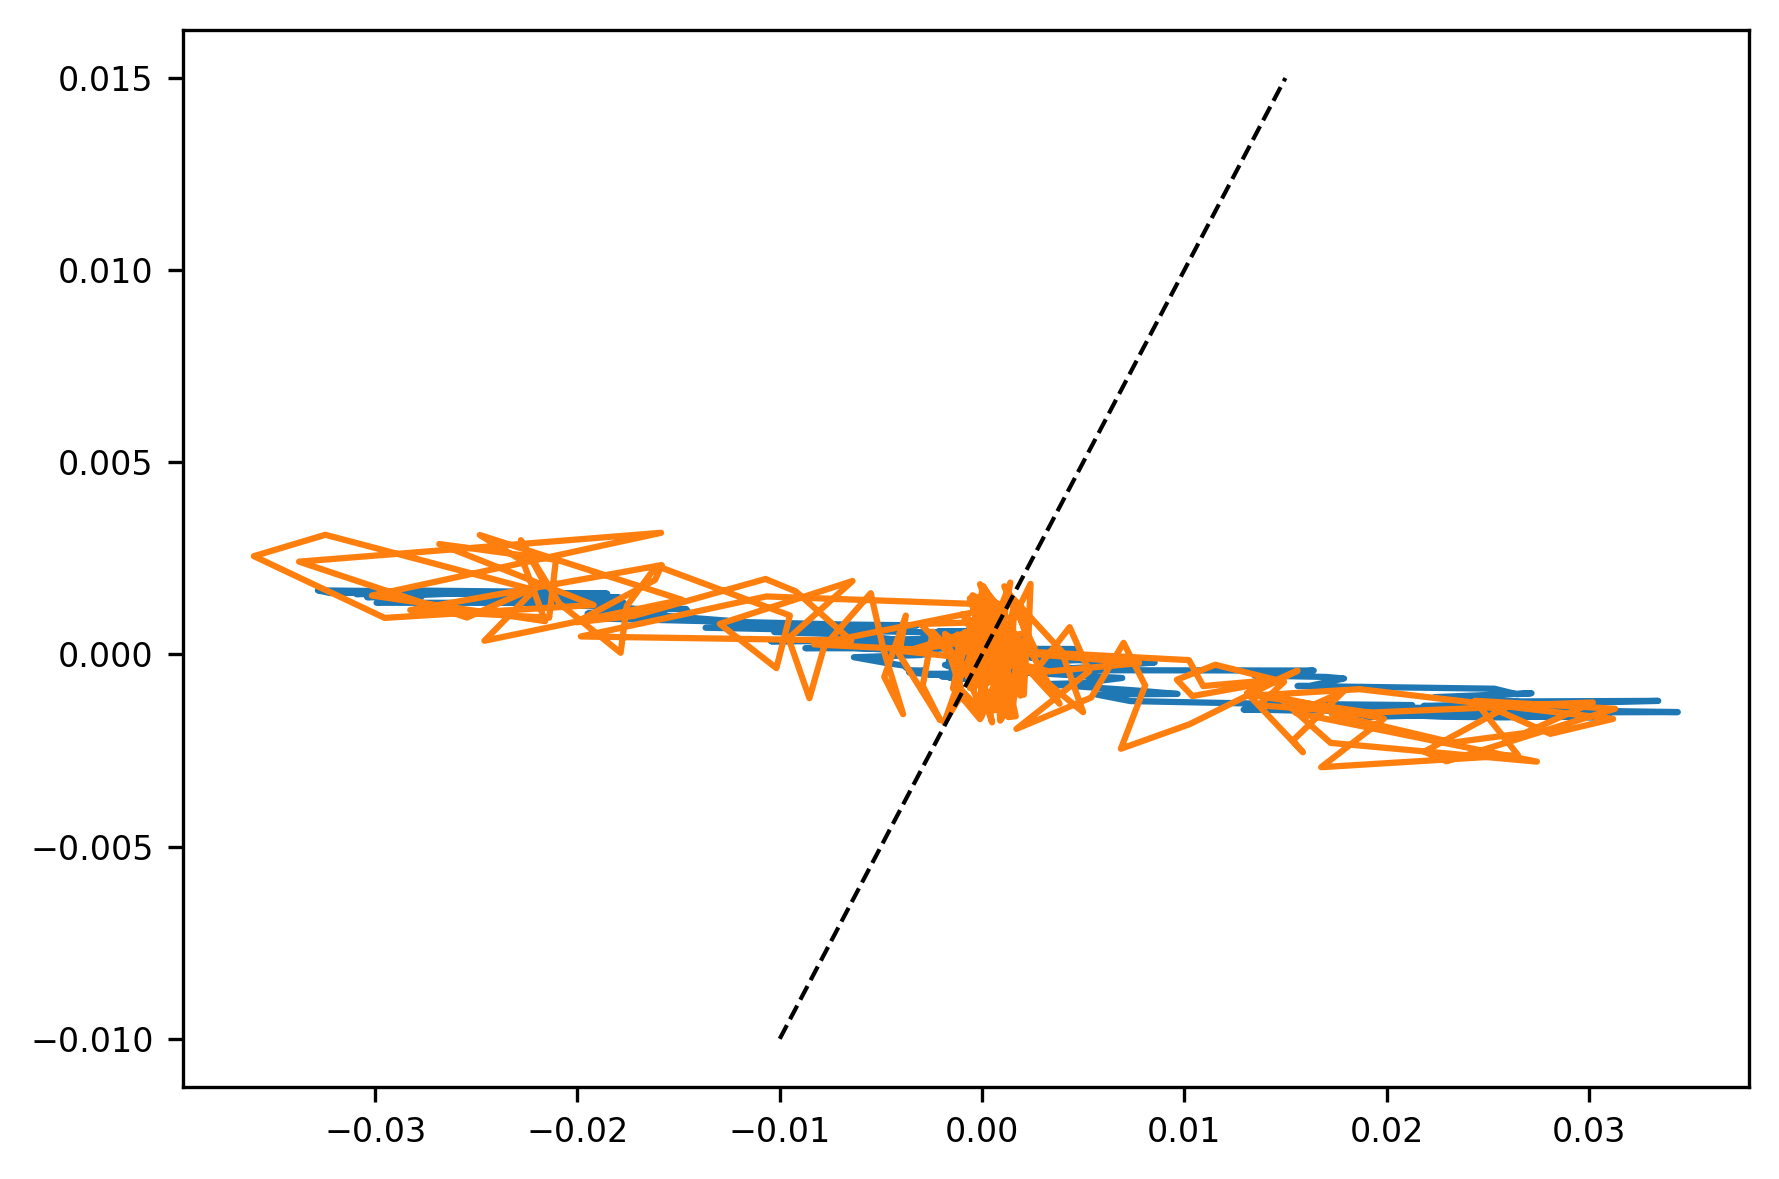

In [ ]:

def proj_zero_sum(v):
    return v - v.mean()
ETA = ETA_VALUES[1]
fig, ax = plt.subplots(figsize=(6, 4))
for AMPAR in AMPAR_VALUES:
    if AMPAR == 1.0:
        RIN = 1.0
    else:
        RIN = 1.27
    for TEMP in TEMP_VALUES[::-1]:
        for THETA in SIG_THETA_VALUES[::-1]:
            idir1 = 0 
            neurons = tensors[AMPAR, RIN, TEMP, ETA,THETA].shape[0]
            state1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].reshape((neurons, -1))
            mu1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].mean(axis=(1,2))

            linear_response = calculate_R_fast_conserved(state1, neurons, TEMP, AMPAR, RIN)
            idir2= 1
            # for idir2 in range(len(IDIR_VALUES)):
            if idir1 == idir2:
                continue
            mu2 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir2].mean(axis=(1,2))
            delta_mu = mu1 - mu2
            delta_mu = delta_mu - delta_mu.mean()
            delta_x = get_bump(IDIR_VALUES[idir1], neurons,I_SIGMA_VALUES[0], I_STR_VALUES[0]) - get_bump(IDIR_VALUES[idir2], neurons, I_SIGMA_VALUES[0], I_STR_VALUES[0])
            delta_x = delta_x 
            delta_mu_estimate = AMPAR*linear_response @ delta_x
            delta_mu_estimate = delta_mu_estimate-delta_mu_estimate.mean()
            print(delta_mu_estimate.sum(), delta_mu.sum())
            plt.plot(delta_mu, delta_mu_estimate)# label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}, idir2={IDIR_VALUES[idir2]}')
            #Compare Norms 
            print('AMPAR:', AMPAR, 'RIN:', RIN, 'TEMP:', TEMP, 'THETA:', THETA, 'idir2:', IDIR_VALUES[idir2])
            print(f'Norm delta mu: {np.linalg.norm(delta_mu)}, Norm delta mu estimate: {np.linalg.norm(delta_mu_estimate)}')
            
            y = proj_zero_sum(delta_mu)          # observed
            x = proj_zero_sum(delta_mu_estimate)      # predicted direction

            a = (y @ x) / (x @ x)                # best-fit gain
            res = y - a * x

            r2 = 1 - (res @ res) / (y @ y)
            cos = (y @ x) / (np.linalg.norm(y) * np.linalg.norm(x))

                # print("best slope a =", a)
                # print("R^2 =", r2)
                # print("cosine similarity =", cos)

                
                # state_one_angle = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,0]
                # Neurons, Generations, Trials = state_one_angle.shape
                # state_one_angle = state_one_angle.reshape((Neurons, -1))

                # covariance_full = np.cov(state_one_angle)
                # eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

                # # Define R matrix which is D(1-DJ)^-1 where D matrix is \partial(\sigma(h))/\partial h
                # Mean_R_matrix = calculate_R_fast(state_one_angle, Neurons, TEMP, AMPAR, RIN)
                # eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # pred_full =  eigenvalues_r/RIN #+ (THETA*AMPAR*eigenvalues_r)**2
                # ax.plot(pred_full,eigenvalues_full, 'o', markersize=2, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')

ax.plot([-.01, 0.015], [-.01, 0.015], 'k--', lw=1)
# plt.xlim(0,0.5)
# plt.ylim(0,0.3)
# plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
for AMPAR in AMPAR_VALUES:
    if AMPAR == 1.0:
        RIN = 1.0
    else:
        RIN = 1.27
    for TEMP in TEMP_VALUES[::-1]:
        for THETA in SIG_THETA_VALUES[::-1]:
            idir1 = 0 
            idir2 = 1
            state1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].reshape((neurons, -1))
            x1 = get_bump(IDIR_VALUES[idir1], neurons, I_SIGMA_VALUES[0],I_STR_VALUES[0] )
            x2 = get_bump(IDIR_VALUES[idir2], neurons, I_SIGMA_VALUES[0],I_STR_VALUES[0] )
            dx = x1 - x2
            eval, evec = np.linalg.eigh(np.cov(state1))
            projection = evec @ dx#//np.linalg.norm(dx)
            # plt.plot(eval[:-1],(projection**2)[:-1])
            # plt.hist(projection**2, density=True, bins=50, alpha=0.5, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')

            idir2 = 2
            state1 = tensors[AMPAR, RIN, TEMP, ETA,THETA][:,:,:,idir1].reshape((neurons, -1))
            x1 = get_bump(IDIR_VALUES[idir1], neurons, I_SIGMA_VALUES[0],I_STR_VALUES[0] )
            x2 = get_bump(IDIR_VALUES[idir2], neurons, I_SIGMA_VALUES[0],I_STR_VALUES[0] )
            dx = x1 - x2
            eval, evec = np.linalg.eigh(np.cov(state1))
            projection = evec @ dx #//np.linalg.norm(dx)
            plt.hist(projection**2, bins=50,density = True, alpha=0.5, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')
            plt.legend()
            ASDF
            # plt.plot(eval[:-1],(projection**2)[:-1])
            # plt.hist(projection, bins=50, alpha=0.5, label=f'gamma={THETA}, Temp={TEMP}, Ampar={AMPAR}, Rin={RIN}')


In [25]:
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)-1):
    for TEMP in TEMP_VALUES[::-1]:
            for THETA in SIG_THETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA, THETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))
                
                # FULL COVARIANCE
                covariance_full = np.cov(state_one_angle)
                eigenvalues_full, eigenvectors_full = np.linalg.eigh(covariance_full)

                # CALCULATE DELTA MU AND SNR             
                mu1 = tensors[AMPAR, RIN, TEMP, ETA, THETA][:,:,:,idir].reshape((Neurons, -1)).mean(axis=1) 
                mu2 = state_one_angle.mean(axis=1)
                delta_mu = mu1 - mu2
                snr = delta_mu.T @ np.linalg.pinv(covariance_full) @ delta_mu


                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR, RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
                bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR* Mean_R_matrix @ delta_x_bump
                
                ## PREDICTIONS FOR SNR
                # overlap_term = eigenvalues_r**2 * (eigenvectors_r.T @ delta_x_bump)**2
                # cov_eval = ((ETA*eigenvalues_r/TEMP)**2 + eigenvalues_r)
                # snr_predicted_eigenvalues = np.sum(overlap_term/cov_eval)

                # predicted_covariance = AMPAR*(ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN**2 * AMPAR)
                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP/(RIN)

                snr_predicted_eigenvalues = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                
                snr_actual[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr
                snr_predicted[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted_eigenvalues


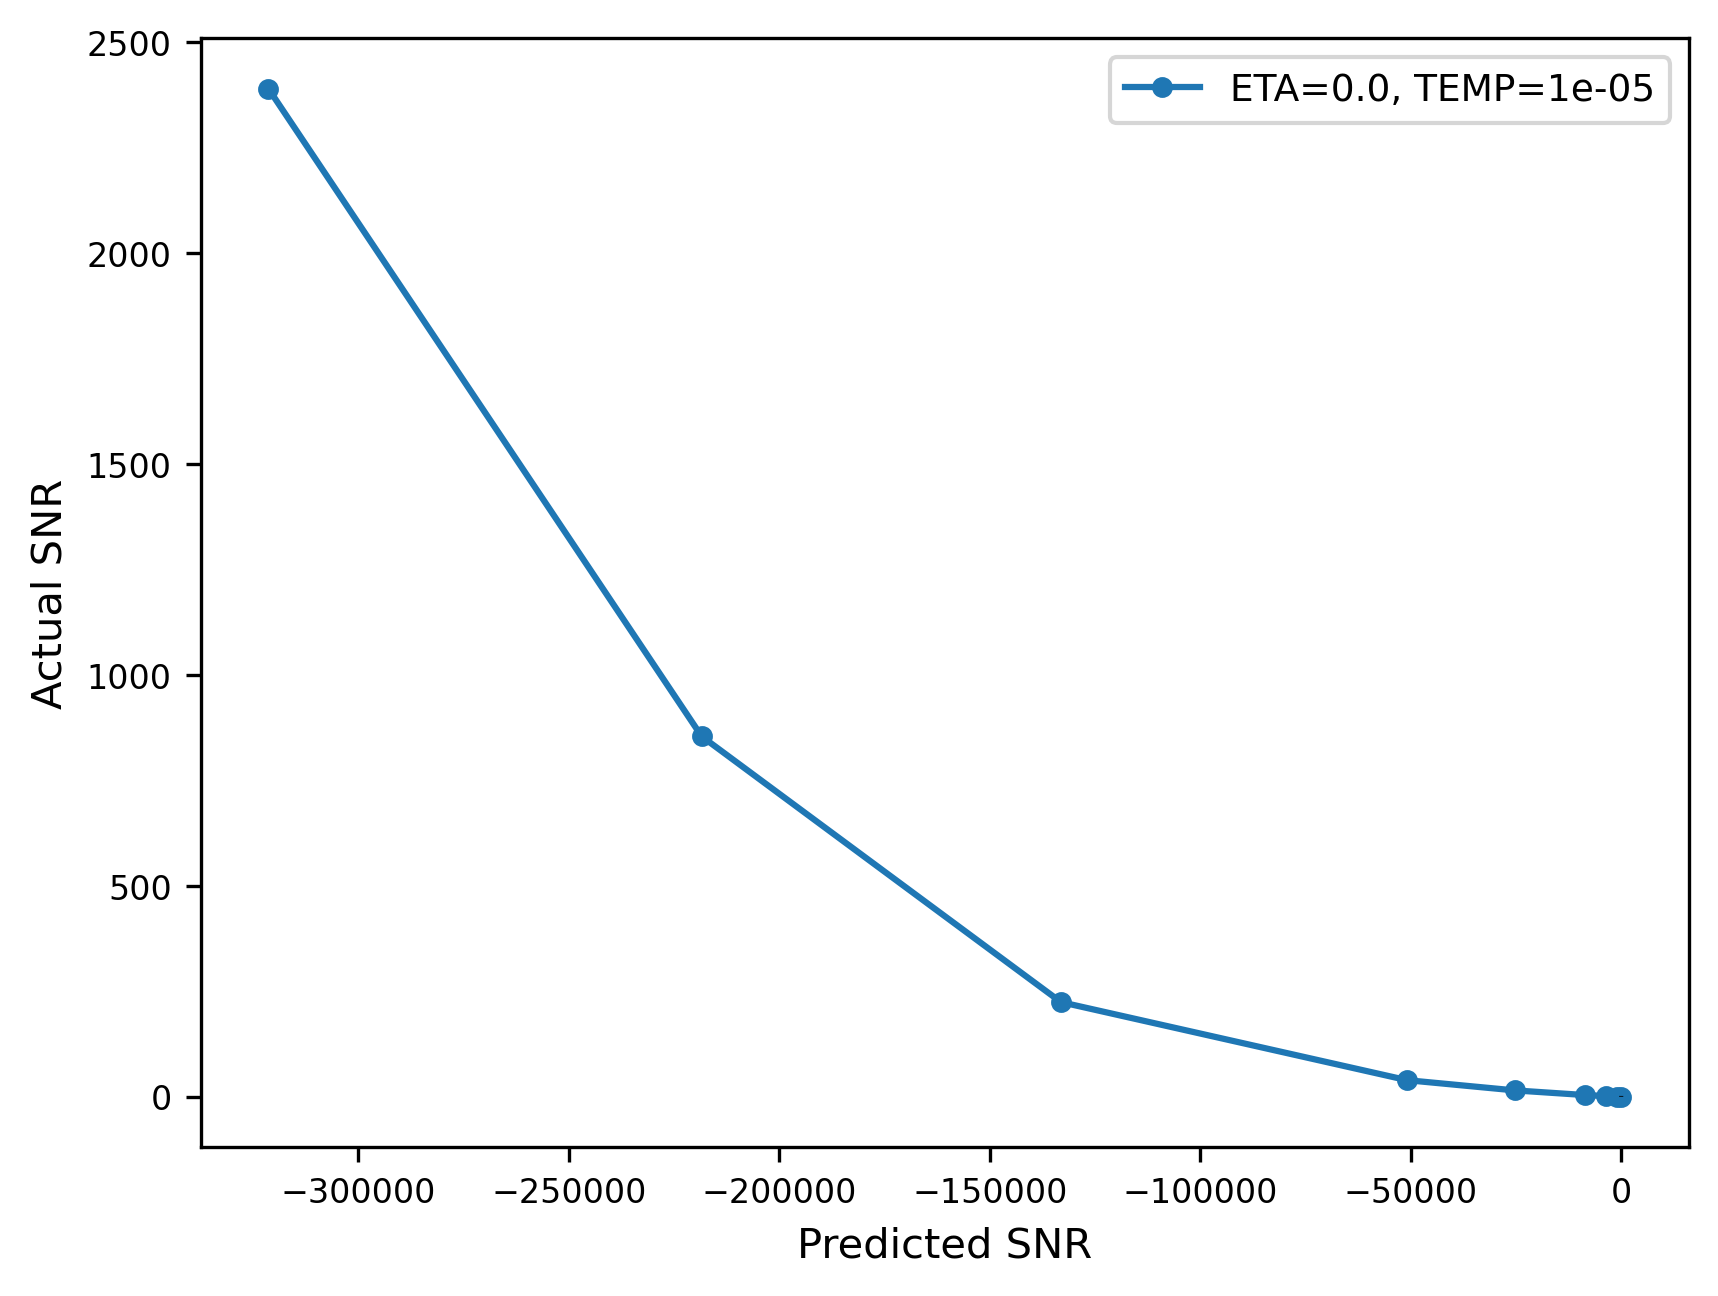

In [ ]:
max_idir = len(IDIR_VALUES)-2
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        # if temp==0.01 and eta==0.0:
        #     continue
        # if temp==0.01 and eta==0.04:
        #     continue
  
        plt.plot(snr_predicted[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), snr_actual[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")
plt.plot([0,2], [0,2], 'k--', lw=1  )
# plt.xlim(0,10)
# plt.ylim(0,10)
plt.legend()
plt.show()

In [26]:
# Checking effect of food restriction on SNR


AMPAR = 1.0
RIN = 1.0
Neurons = 500

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_CTR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU

                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_CTR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted
AMPAR = 0.64
RIN = 1.27

snr_actual = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
snr_predicted_FR = np.zeros((len(IDIR_VALUES), len(TEMP_VALUES), len(ETA_VALUES)))
for idir in range(1, len(IDIR_VALUES)):
    bump = get_bump(IDIR_VALUES[0], Neurons, 0.05, 0.1)
    bump_dx  = get_bump(IDIR_VALUES[idir], Neurons, 0.05, 0.1)
    for TEMP in TEMP_VALUES[::-1]:
            for ETA in ETA_VALUES[::-1]:
                state_one_angle = tensors[AMPAR, RIN, TEMP, ETA][:,:,:,0]
                Neurons, Generations, Trials = state_one_angle.shape
                state_one_angle = state_one_angle.reshape((Neurons, -1))

                # PREDICITONS FOR R 
                Mean_R_matrix = calculate_R(state_one_angle, Neurons, TEMP, Generations, AMPAR,RIN)
                eigenvalues_r, eigenvectors_r = np.linalg.eigh(Mean_R_matrix)
                # PREDICTIONS FOR DMU
                delta_x_bump = bump_dx - bump
                delta_mu_predict = AMPAR*Mean_R_matrix @ delta_x_bump

                predicted_covariance = (ETA*Mean_R_matrix)@(ETA*Mean_R_matrix) + Mean_R_matrix*TEMP
                snr_predicted = delta_mu_predict.T @ np.linalg.pinv(predicted_covariance) @ delta_mu_predict
                snr_predicted_FR[idir-1, TEMP_VALUES.index(TEMP), ETA_VALUES.index(ETA)] = snr_predicted

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 500 is different from 100)

/tmp/ipykernel_3456/4066449938.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')


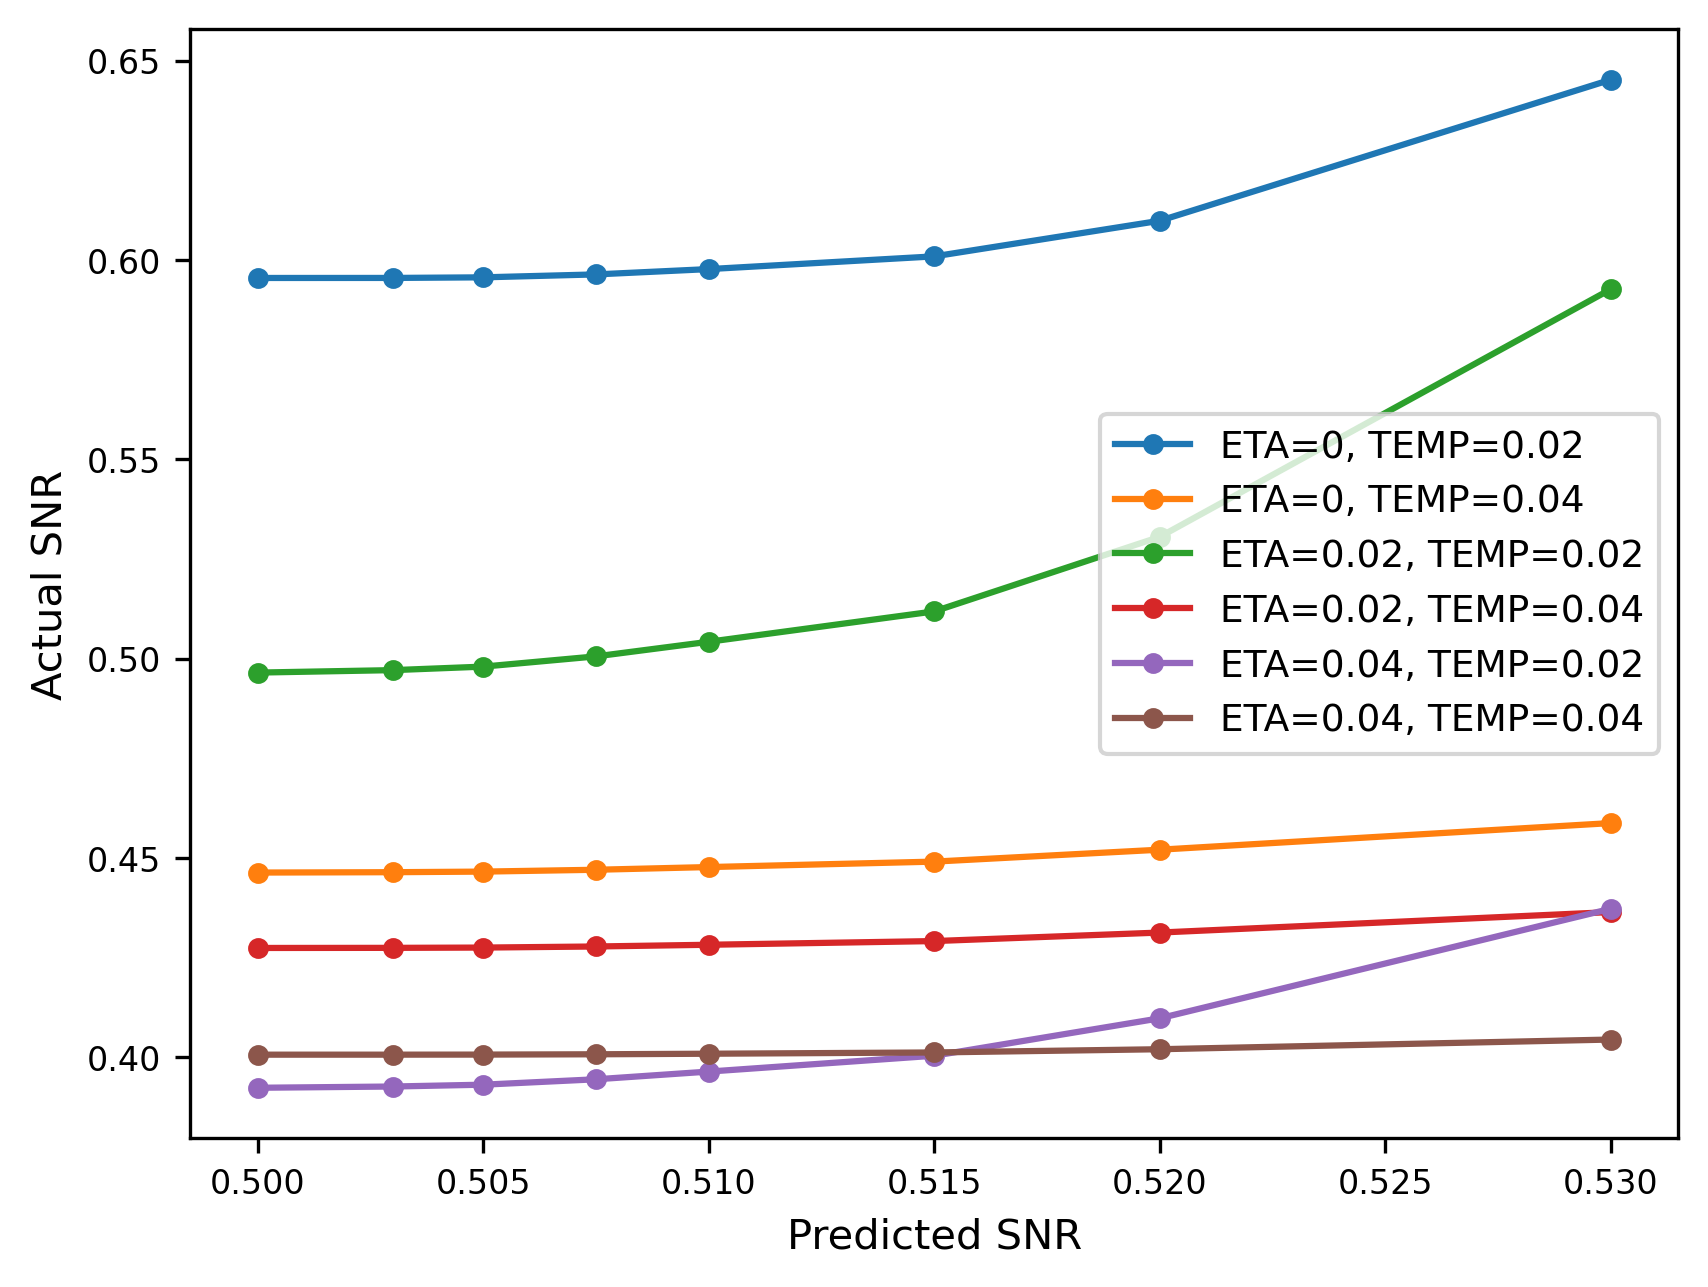

In [150]:
max_idir = len(IDIR_VALUES)
for eta in ETA_VALUES:
    for temp in TEMP_VALUES:
        plt.plot(IDIR_VALUES, snr_predicted_FR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten()/snr_predicted_CTR[:max_idir,TEMP_VALUES.index(temp),ETA_VALUES.index(eta)].flatten(), 'o-',markersize = 4, label=f'ETA={eta}, TEMP={temp}')
#marker size
plt.xlabel("Predicted SNR")
plt.ylabel("Actual SNR")

plt.legend()
plt.show()